# Introduction

As single-cell RNA sequencing technology advances rapidly, it is conceivable to investigate gene connections in a cell type-specific way. However, Single-cell network inference and analysis is a non-trivial task that requires solid statistical background, especially for data preprocessing and proper interpretation of results. As a result, novice researchers frequently struggle to choose the most suitable algorithms for their projects. In addition, several packages are needed for each step of a standard network analysis, and their distinct syntaxes can hinder interoperability between packages, particularly for non-advanced Python users. 

Here we propose SCANet, a new python package that incorporates the inference of gene co-expression networks from single-cell gene expression data and a complete analysis of the identified modules through trait and cell type associations, hub genes detection, deciphering of co-regulatory signals in co-expression, and drug-gene interactions identification. This will likely accelerate network analysis pipelines and advance systems biology research.

In this Jupyter Notebook, we explored all aspects of gene coexpression networks (GCNs) using SCANet through a full analysis of the 3k PBMCs from 10x Genomics.

In [30]:
#Import modules, packages, functions, etc ... 

import scanet as sn
import pandas as pd

# Read the data 

3k PBMCs from 10x Genomics.        
The data consists in 3k PBMCs from a Healthy Donor and is freely available from 10x Genomics.        
The exact same data is also used in Seurat’s basic clustering tutorial.        
Its freely available scanpy.datasets.pbmc3k()        

In [31]:
# Read the data 
data_path = "data/pbmc3k_raw.h5ad"
adata = sn.pp.read_h5ad(data_path, pr_process="Yes")
adata

filtered out 16104 genes that are detected in less than 1 cells


AnnData object with n_obs × n_vars = 2700 × 16634
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [32]:
# Very important the var_names muts be genes names not gene ID
# Checking gene names. Please change if necessary ...!

print(list(adata.var_names)[:15])

# In case not here how to do it
# adata.var = adata.var.set_index('feature_name')
# print(list(adata.var_names)[:15])

['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9', 'FAM87B', 'LINC00115', 'FAM41C', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4', 'RP11-54O7.11', 'ISG15']


# Step-by-step pr-processing and quality control

Plotting the total number of reads detected per cell.         
Cells with few reads are likely to have been broken or failed to capture a cell, and should thus be removed.        
Cells with very high reads are likely doublets        

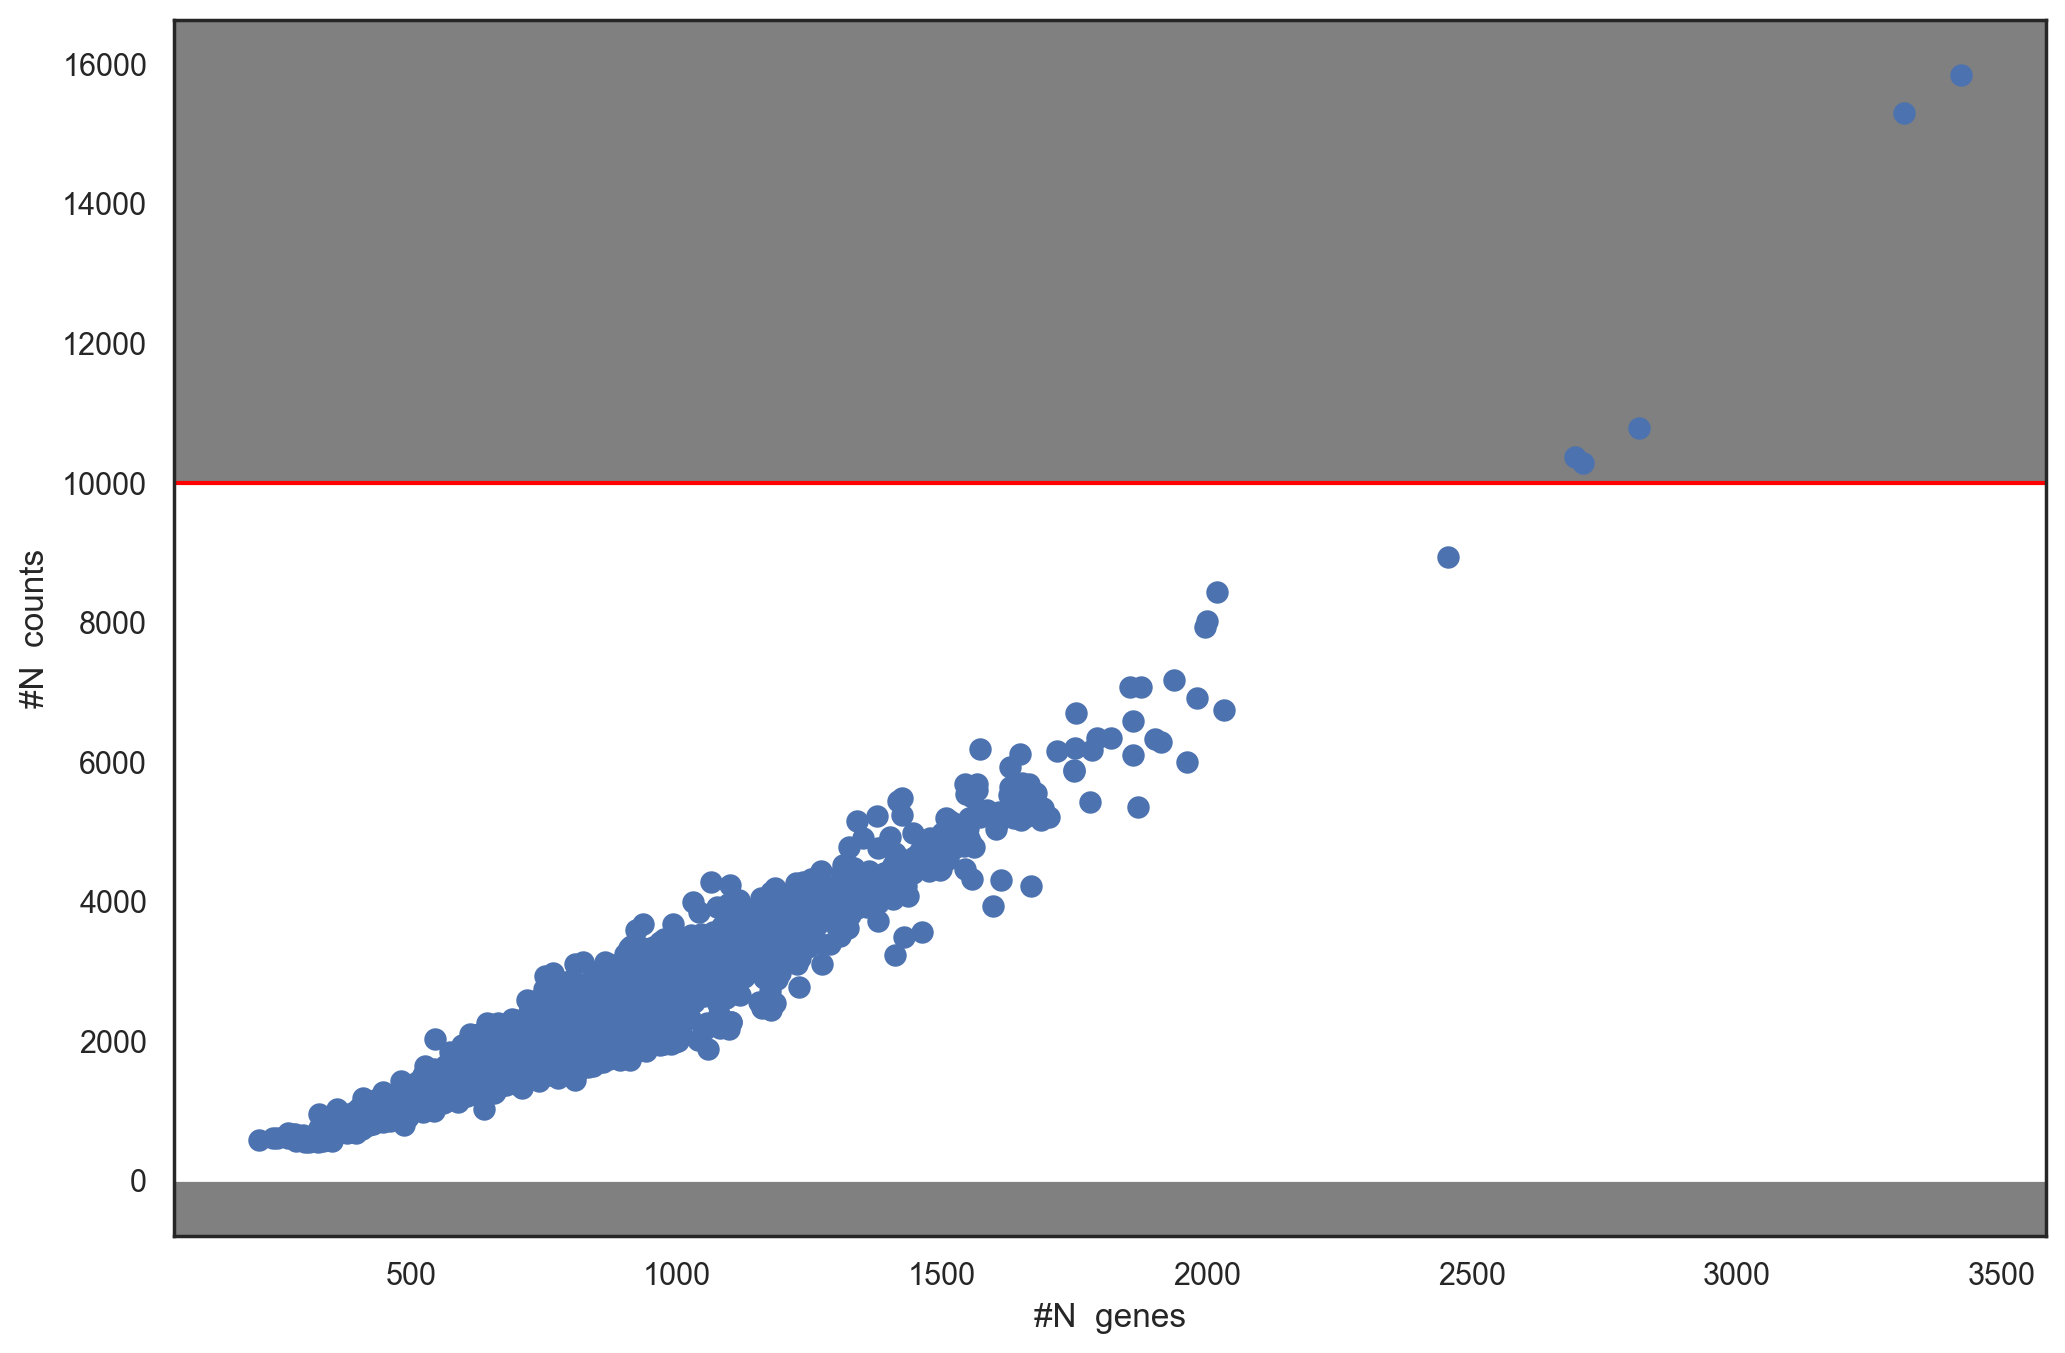

Used max_counts is 10000


In [33]:
# Thresholding decision: cells

sn.pp.plot_filter_cells(adata, max_counts=10000, dot=50, fig_size=(12,8))

In [34]:
# Cells with too many counts are probaly doublet cells/outliers. 
# Filtering cells based on #N counts

adata = sn.pp.filter_cells(adata, max_counts=10000)

Total number of cells: 2700
Number of cells after min genes filter: 2700
filtered out 5 cells that have more than 10000 counts
Number of cells after max count filter: 2695


Filter cells based on how many expressed genes (we want to keep it as a normal distribution and avoid noise picks)       
In addition to ensuring sufficient sequencing depth for each sample, we also want to make sure that the reads are distributed across the transcriptome. Thus, we count the total number of unique genes detected in each cell.


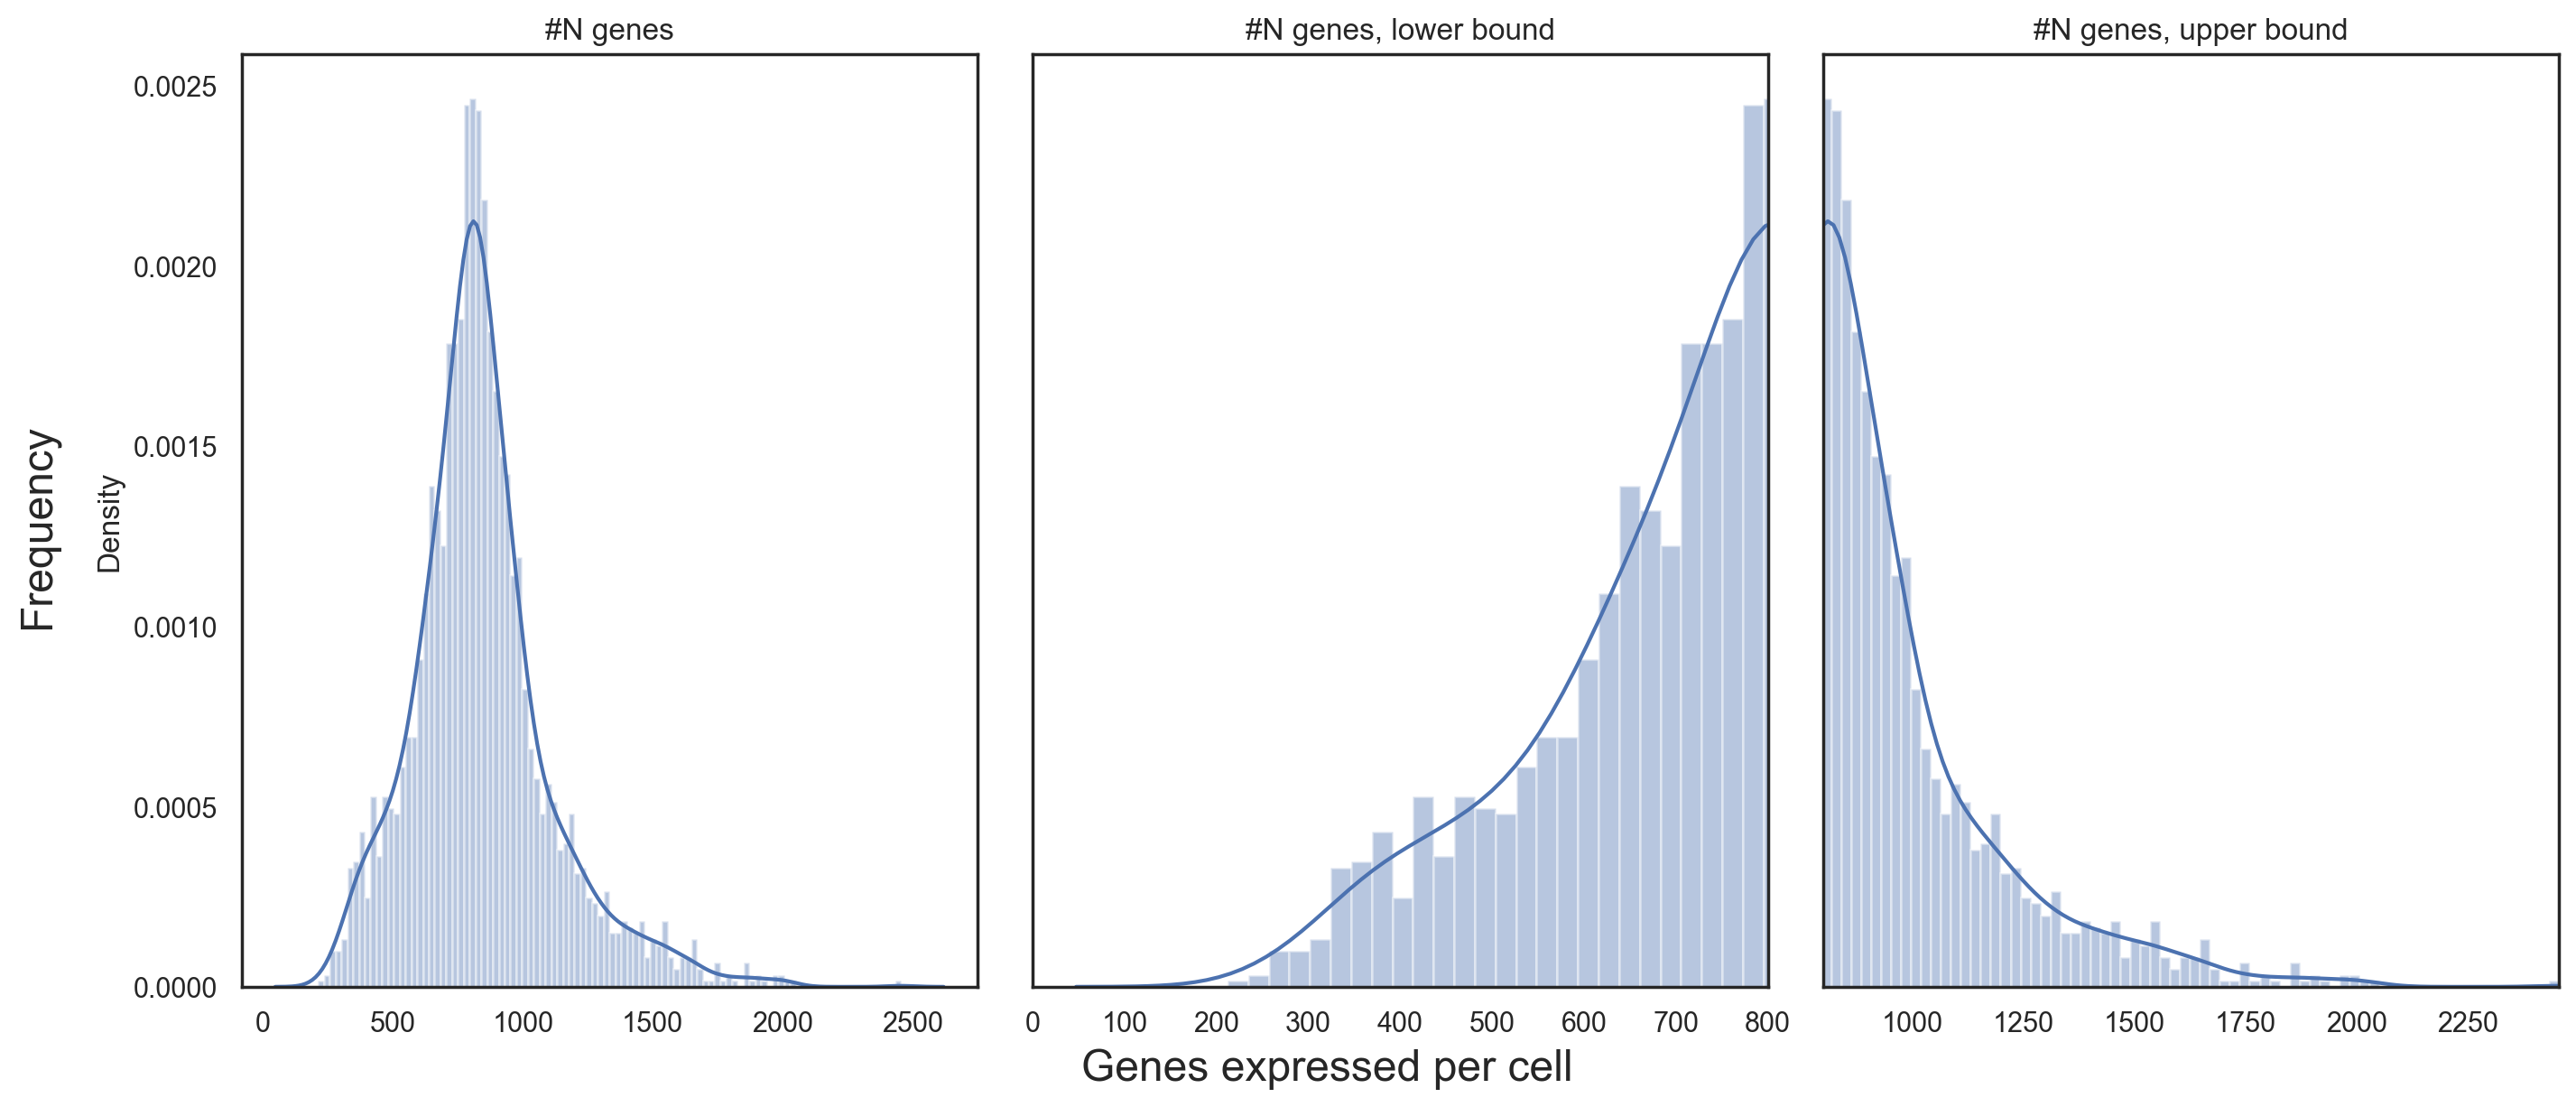

In [35]:
# Thresholding decision: genes
# Use the plot in left to decide on the lowerbound upperbound values

sn.pp.plot_cells_by_n_genes(adata, lowerbound=800, upperbound=800, nbins=100, fig_size=(14,6))

In [36]:
#Filtering cells based on #N expressed genes

adata = sn.pp.filter_cells_by_n_genes(adata, min_n_genes=400, max_n_genes=1500)

Total number of cells: 2695
Number of cells after cell filter: 2522


Quality control for genes       
It is typically a good idea to remove genes whose expression level is considered "undetectable". We define a gene as detectable if at least two cells contain more than 5 reads from the gene. However, the threshold strongly depends on the sequencing depth. It is important to keep in mind that genes must be filtered after cell filtering since some genes may only be detected in poor quality cells.

In [37]:
# Filter (low detected genes) genes based on how mnay cells that they are expressed in 

adata = sn.pp.filter_genes(adata, min_cells=3)

Total number of genes: 16634
filtered out 3188 genes that are detected in less than 3 cells
Number of genes after filtering: 13446


Mitochondrial read fractions are only high (light blue color) in particularly low count cells with few detected genes. This could be indicative of damaged/dying cells whose cytoplasmic mRNA has leaked out through a broken membrane, and thus, only mRNA located in the mitochondria is still conserved. These cells are filtered out by our count and gene number thresholds. 

Total number of cells: 2522
Number of cells after MT filter: 2481


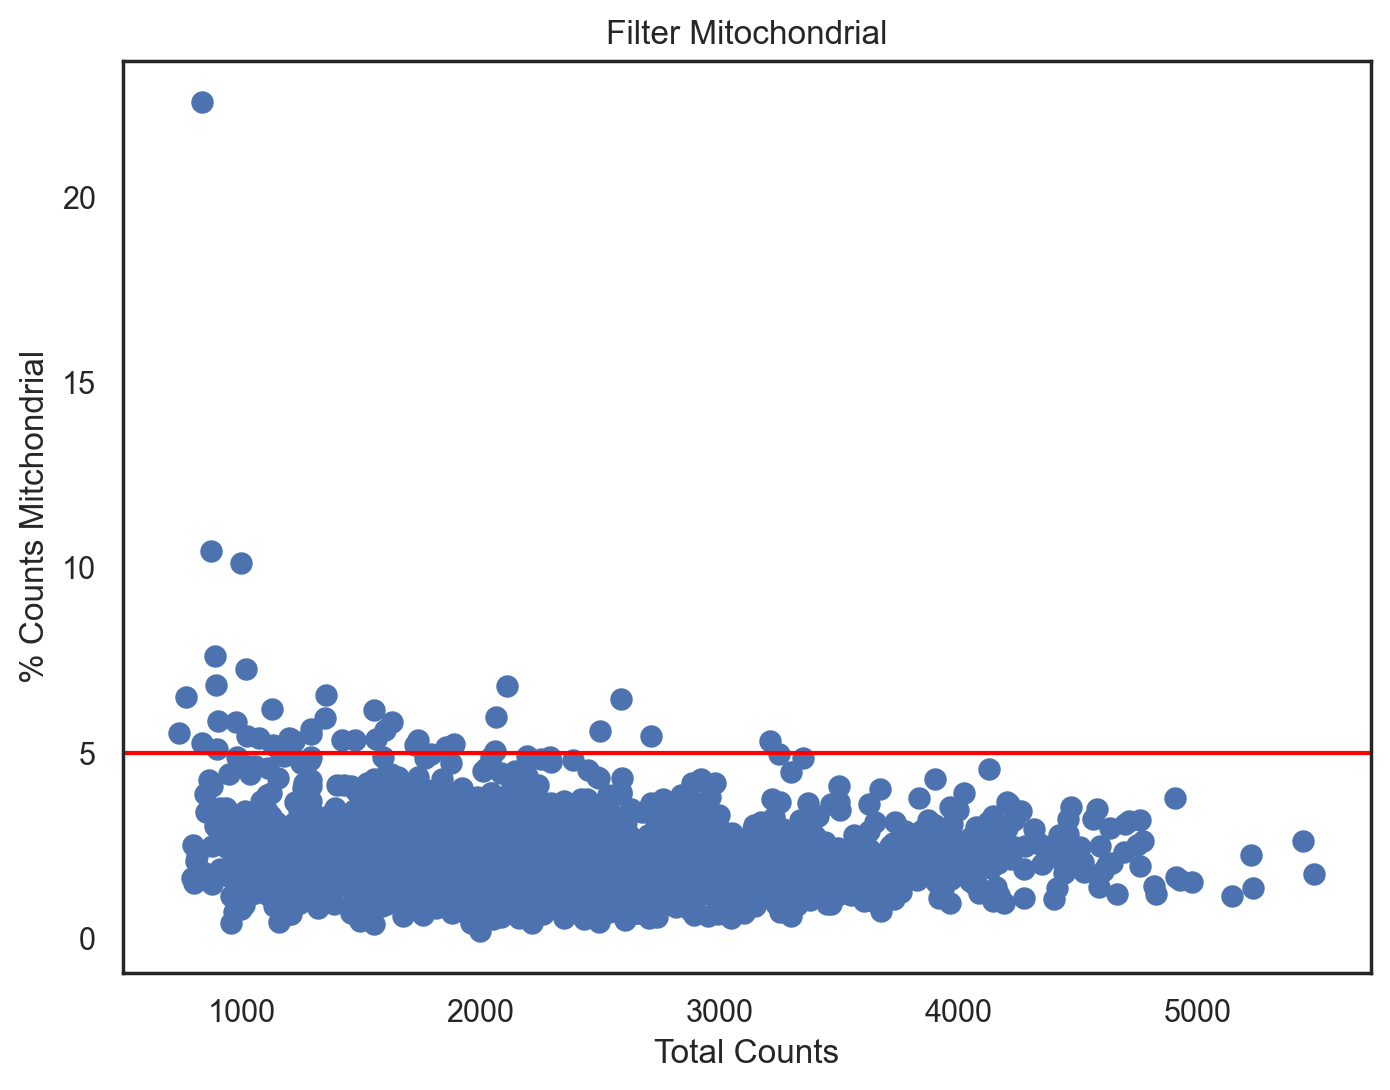

In [38]:
# Use Mitochondrial gene expression levels to filter out broken cells.

sn.pp.plot_filter_mitochondrial(adata, thres=5, dot=50, fig_size=(8,6))
adata = sn.pp.filter_mitochondrial(adata, max_mt_percent=5)

In [39]:
# Total-count normalize (library-size correct) 
# The data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.

adata = sn.pp.log_normalize(adata, target_sum=1e6, use_log=True)

normalizing counts per cell
    finished (0:00:00)


Highly variable gene.   
Highly variable gene discovery allows the detection of genes that contribute strongly to cell-to-cell variation within a homogeneous cell population.

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


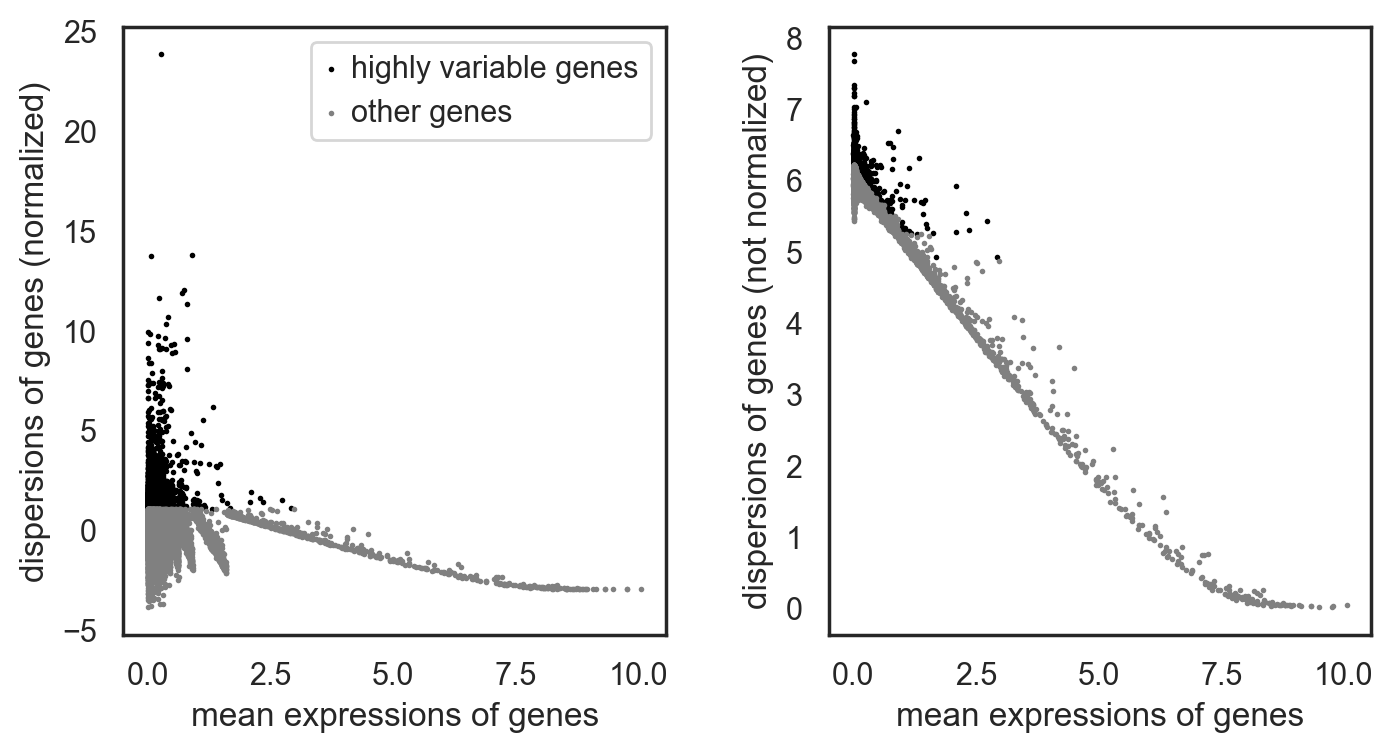

In [40]:
# Use only highly variable genes for the analysis not all genes !!!

adata = sn.pp.extract_highly_variable_genes(adata, n_top_genes=2000, plot=True)
adata = adata[:, adata.var.highly_variable]

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


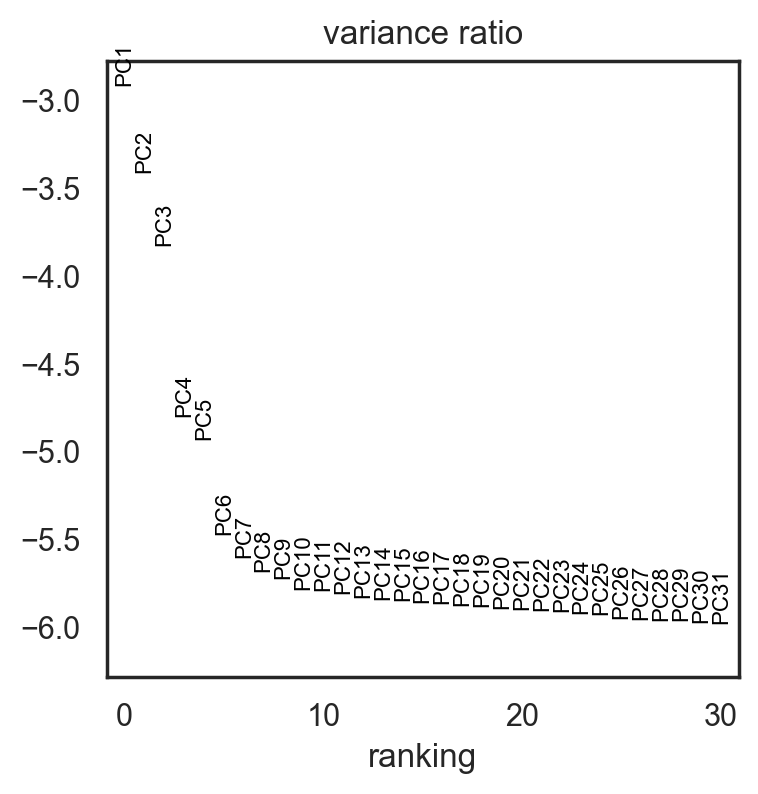

In [41]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells

sn.vz.dimensionality_reduction_parameters(adata)

In [42]:
# Dimensionality reduction

adata = sn.vz.dimensionality_reduction(adata, method="UMAP", n_pcs=10, n_neighbors=10)

Calculating dimensionality reduction :UMAP
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
it tooks :0.08030566374460855 minutes.


In [43]:
# Seclect the annotation you want to work with:
# Available annotations:"
print(list(adata.obs))

['n_genes', 'percent_mito', 'n_counts', 'louvain', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt']


In [44]:
cell_annoatation="louvain"


 Available method are: PCA, t-SNE,  UMAP, or ALL


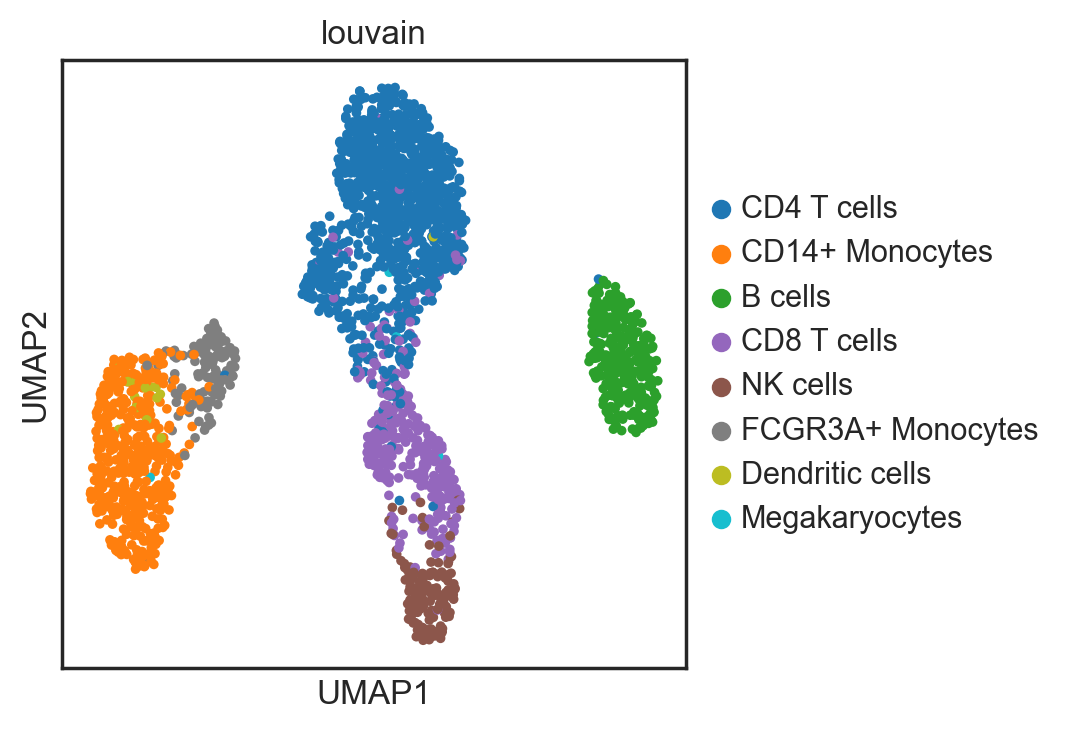

In [45]:
# Visualization

cell_annoatation="louvain"
sn.vz.visualization(adata, method="UMAP", color=cell_annoatation)

In [46]:
# Saving the data

name_reduced = "data/"+data_path.split("/")[-1].split(".h5ad")[0]+"_processed.h5ad"
print(name_reduced)
adata.write_h5ad(name_reduced)

data/pbmc3k_raw_processed.h5ad


In [47]:
adata

AnnData object with n_obs × n_vars = 2481 × 2000
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Representative cells 

Grouping of neighboring single cells where the data from every single cell is combined into a single pseudo-sample that represents the overall signal across these cells. Cells for each cell type are sub-clustered into N (num_rep_cells) sub-cluster each sub-cluster is then turned into a single representative cell by averaging the gene expression profiles across its cells.

In [48]:
# Representative cells 

adata_r = sn.pb.representative_cells(adata, num_rep_cells=50, cell_anno=cell_annoatation)

clusters in the data louvain
CD4 T cells          1110
CD14+ Monocytes       448
B cells               319
CD8 T cells           307
NK cells              151
FCGR3A+ Monocytes     124
Dendritic cells        18
Megakaryocytes          4
dtype: int64

The following cell clusters will be deletedas their size if less than the specified number ofrepresentative cells:
['Dendritic cells', 'Megakaryocytes']
data type: SparseCSRView

Selected representative cells for each cluster __SCANclusters__
B cells              50
CD14+ Monocytes      50
CD4 T cells          50
CD8 T cells          50
FCGR3A+ Monocytes    50
NK cells             50
dtype: int64


In [49]:
# The reduced data

adata_r

AnnData object with n_obs × n_vars = 300 × 2000
    obs: '__SCANclusters__'
    var: 'Genes'

computing PCA
    with n_comps=50
    finished (0:00:00)


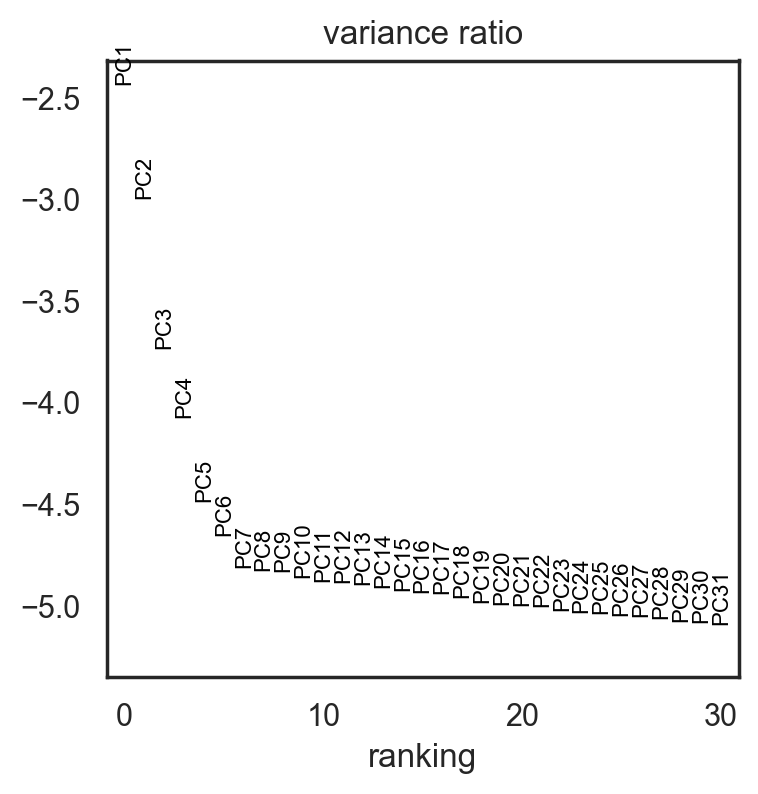

In [50]:
sn.vz.dimensionality_reduction_parameters(adata_r)

In [51]:
adata_new = sn.vz.dimensionality_reduction(adata_r, method="UMAP", n_pcs=10, n_neighbors=5)

Calculating dimensionality reduction :UMAP
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)
it tooks :0.017407198746999104 minutes.


... storing '__SCANclusters__' as categorical



 Available method are: PCA, t-SNE,  UMAP, or ALL


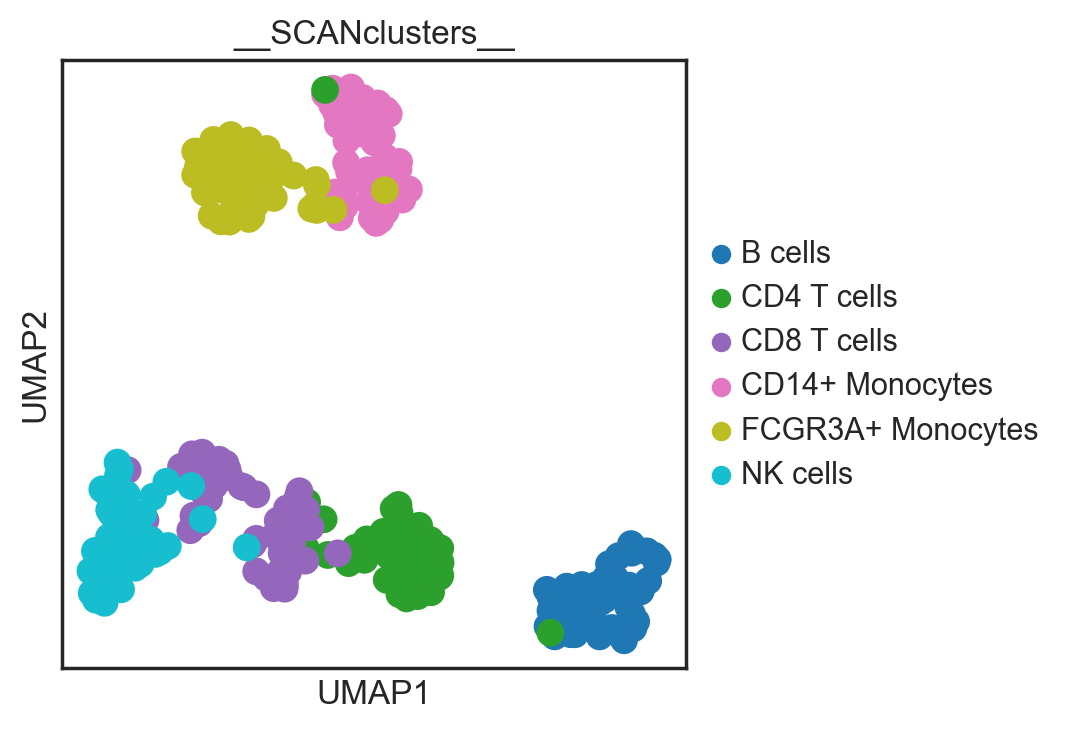

In [52]:
sn.vz.visualization(adata_new, method="UMAP", color='__SCANclusters__')

In [53]:
# Saving the data

name_reduced = "data/"+data_path.split("/")[-1].split(".h5ad")[0]+"_reduced.h5ad"
print(name_reduced)
adata_r.write_h5ad(name_reduced)

data/pbmc3k_raw_reduced.h5ad


# CO-expression analysis

In [55]:
# Read the reduced data

data_path = "data/pbmc3k_raw_reduced.h5ad"
adata_r = sn.pp.read_h5ad(data_path)
adata_r

AnnData object with n_obs × n_vars = 300 × 2000
    obs: '__SCANclusters__'
    var: 'Genes'
    uns: '__SCANclusters___colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

we can reconstruct a gene coexpression network (GCN) with the WGCNA algorithm (Langfelder and Horvath 2008). First of all, we need to identify the most suitable SFTpower power that makes the network satisfy the scale-free topology. We do that with the function plot_powers(). Correlation values are raised to a power SFTpower to amplify their distances and, hence, to make the module detection algorithm more powerful. The higher the value of SFTpower, the closer to the scale-free topology the network is. However, a very high SFTpower power reduces mean connectivity, which is not desired. To solve this trade-off, we pick the lowest SFTpower power above a certain threshold 0.8. This makes the network close to the scale-free topology without dramatically reducing the mean connectivity.

Possible parameter values

net_type Network type. One of ’signed’, ’signed hybrid’ or ’unsigned’. Default: ’signed’.      
module_merging_threshold Correlation threshold to merge similar modules into a single one. Default: 0.8.    
SFTpower SFT power generated by the function plot_powers.     
cor_method Correlation method. One of "pearson", "biweight" or "spearman". Default is "spearman".    

Data dimension is : 300 Cells and 2000 Genes
[1] 2000  300
[1] "Removing outlier cells ..."
[1] "Removed 1 cells ..."
[1] 2000  299


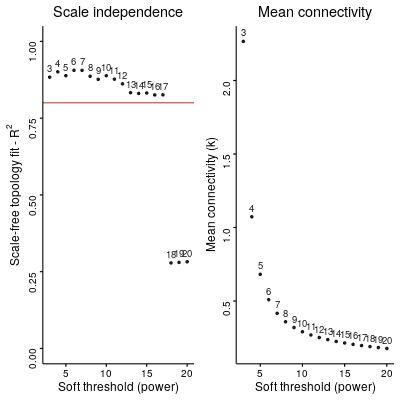

The optimal power to use is : 3.0 or visualize the plot and change the value accordingly.
Tip: If power values are not exponential distributed dont use the maximum value.


3

In [56]:
# Suitable SFTpower power that makes the network satisfy the scale-free topology

SFTpower = sn.co.plot_powers(adata_r, network_type="unsigned", cor_method="pearson")
SFTpower

In [57]:
# Infer the GCN

net = sn.co.co_expression(adata_r, network_type="unsigned", cor_method="pearson", power=SFTpower, module_merging_threshold=0.8)

Data dimension is : 300 Cells and 2000 Genes
[1] 2000  300
[1] "Removing outlier cells ..."
[1] "Removed 1 cells ..."
[1] 2000  299
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


Plotting the dendrogram
NULL


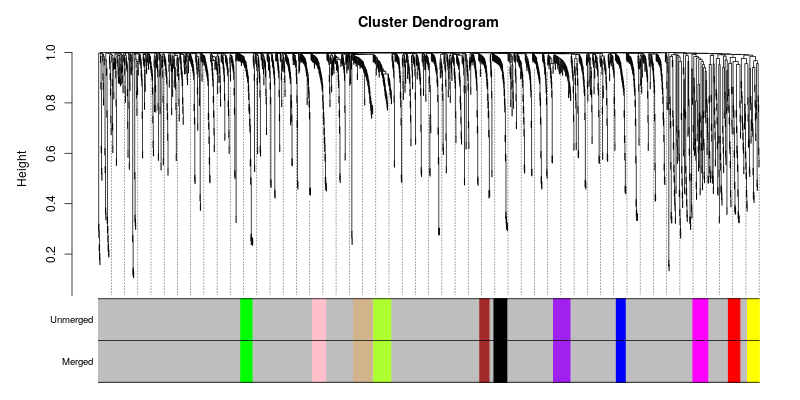

In [58]:
# Dendrogram of genes and modules

sn.co.plot_dendrogram(net,  fig_size=(800,400))

Plotting the eigengene network
NULL


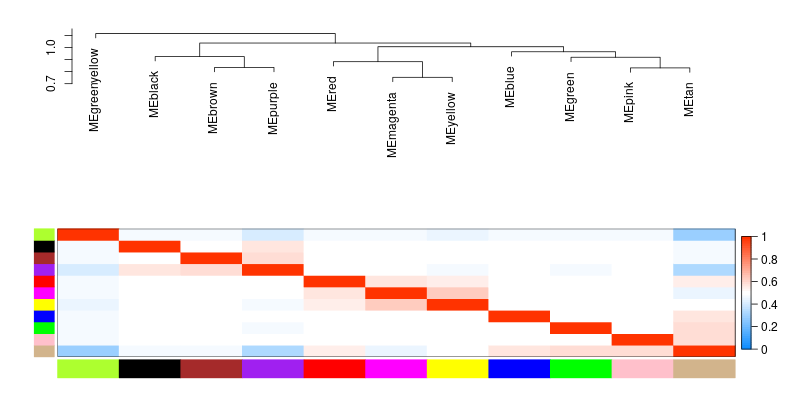

In [59]:
# Heatmap of pairwise correlations between module eigengenes

sn.co.plot_eigengene_network(net, fig_size=(800,400))

Plotting the modules


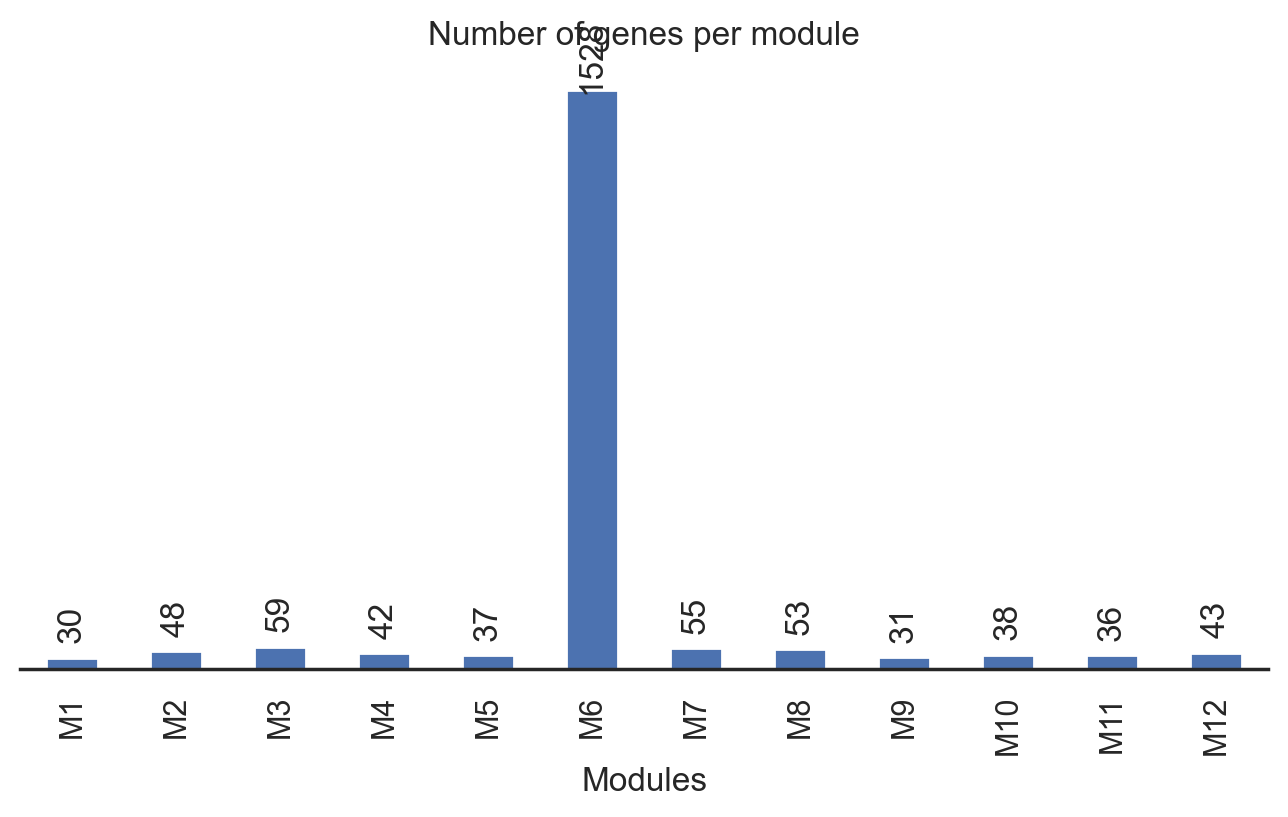

,Module_r,n_genes,genes,Modules
0,blue,30,"[""RP11-96K19.2"", ""AL590452.1"", ""RIT1"", ""BOLA3-...",M1
1,magenta,48,"[""CA6"", ""RP3-329E20.2"", ""PIFO"", ""AQP10"", ""SLC1...",M2
2,tan,59,"[""STMN1"", ""RHOC"", ""CD160"", ""SH2D2A"", ""FCRL6"", ...",M3
3,black,42,"[""HS2ST1"", ""LPGAT1"", ""EIF2AK3"", ""CD200"", ""U2SU...",M4
4,green,37,"[""MIB2"", ""DHRS3"", ""EVA1B"", ""CEPT1"", ""CHI3L2"", ...",M5


In [60]:
# Number of genes per module.

df_modules = sn.co.plot_modules(net, figsize=(8,4))
df_modules.head()

# Hub gene identification

Hub genes are often identified using two different metrics: module membership (MM) (i.e., correlation of a gene to its module eigengene) and degree (i.e., sum of connection weights of a gene to all other genes in the module). Some researchers consider the top 10% genes with the highest degree as hubs, while others consider those with MM > 0.8. To avoid false positives, we combine both metrics and defines hub genes as the top 10% genes with highest degree that have MM > 0.8. Hubs can be identified with the function hub_genes().

Data dimension is : 300 Cells and 2000 Genes
[1] 2000  300
[1] "Removing outlier cells ..."
[1] "Removed 1 cells ..."
[1] 2000  299


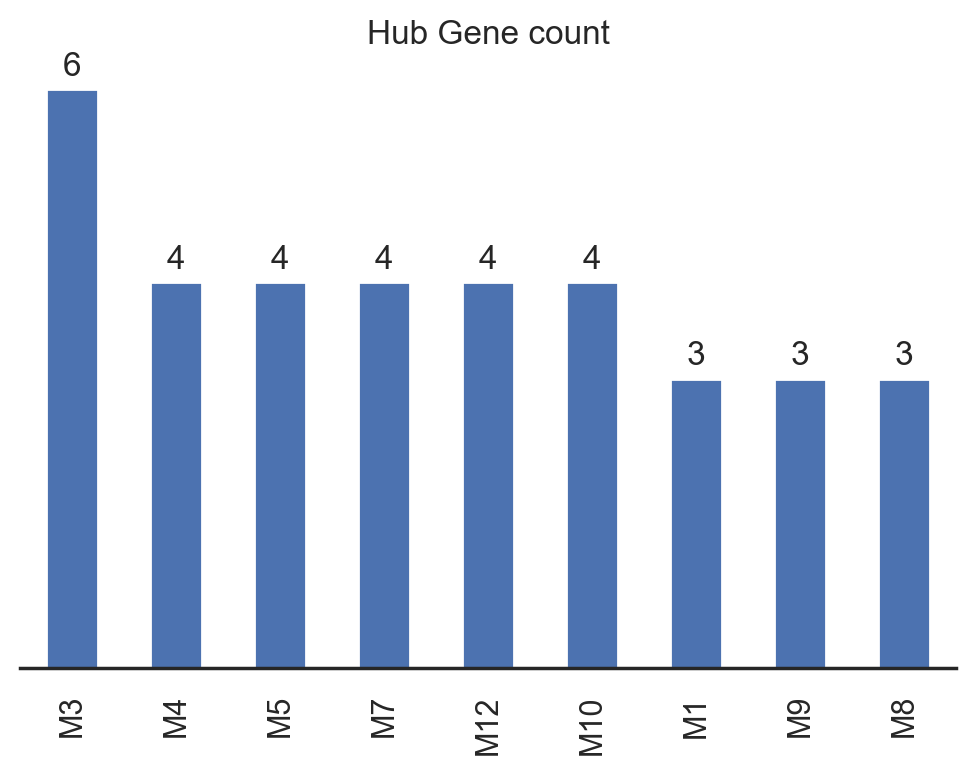

,Gene,kWithin,Modules
0,RP11-277P12.20,7.392159,M4
1,WDR66,7.358127,M4
2,CTB-113I20.2,7.273552,M4
3,MEIG1,7.167886,M4
4,RP11-96K19.2,5.477152,M1


In [61]:
# Hub genes

hub_genes_df = sn.co.hub_genes(adata=adata_r, net=net, figsize=(6,4))
hub_genes_df.head(5)

# Module-Annotation associations

The function modules_to_annotation_cor() can be used to calculate Module-Annotation correlations. This analysis is useful to identify modules that are positively or negatively correlated with particular annotation (such as cell type or diseased viruses healthy), which means that their gene expression levels go up or down in these conditions. Here, cell type will be considered, so we want to identify groups of genes whose expression levels are inhibited or induced in particular cell type.

Data dimension is : 300 Cells and 2000 Genes
[1] 2000  300
[1] "Removing outlier cells ..."
[1] "Removed 1 cells ..."
[1] 2000  299


,Modules,annotation,cor,pvalue
1,M4,B.cells,0.374891,2.065767e-11
2,M4,CD14..Monocytes,-0.142679,1.353137e-02
3,M4,CD4.T.cells,-0.028057,6.289442e-01
4,M4,CD8.T.cells,-0.077924,1.790001e-01
5,M4,FCGR3A..Monocytes,-0.167977,3.577883e-03


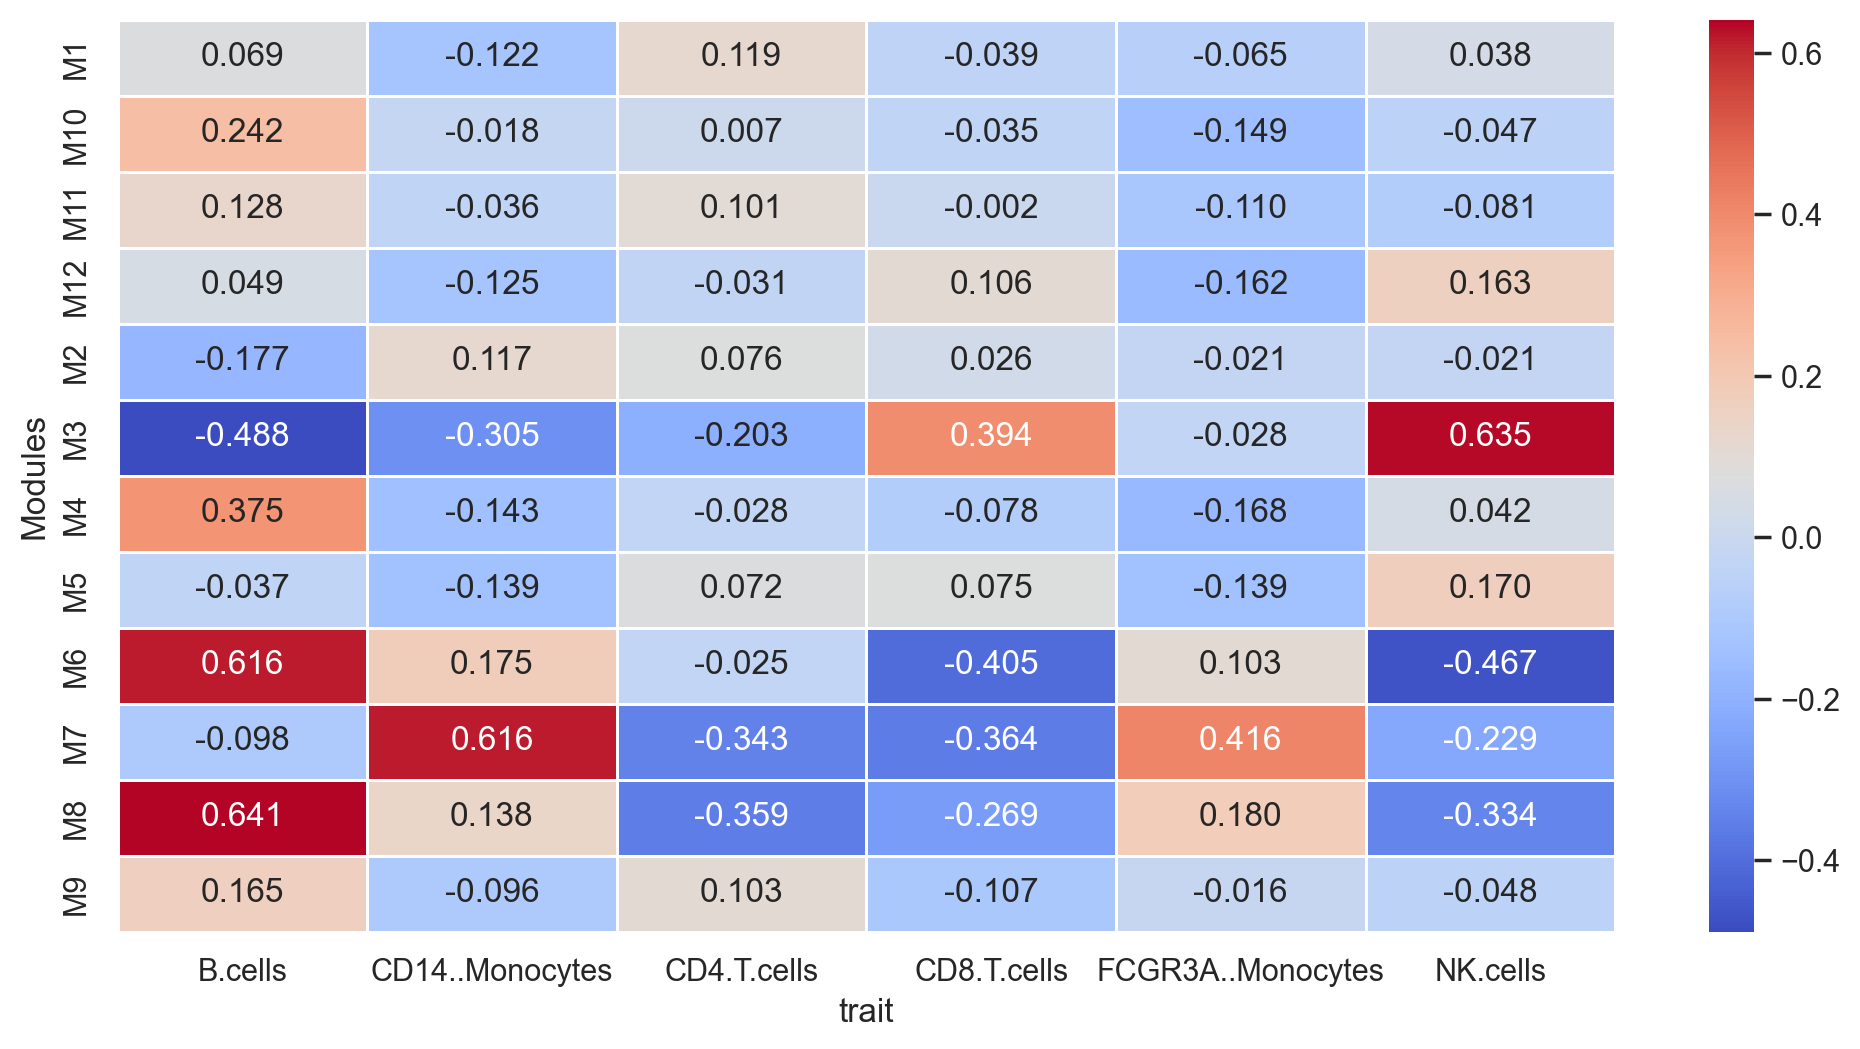

In [62]:
cor = sn.co.modules_to_annotation_cor(adata_r, net, figsize=(12,6), cor_method="spearman")
cor.head(5)

In [63]:
# Filter only the modules that are highly correlated (or >= 0.5)

cor__ = cor[abs(cor["cor"])>=0.5]
cor__

,Modules,annotation,cor,pvalue
26,M7,CD14..Monocytes,0.615684,1.382677e-32
31,M6,B.cells,0.615836,1.321597e-32
49,M8,B.cells,0.641414,4.709380e-36
66,M3,NK.cells,0.635498,3.157962e-35


# Analysis of co-expression modules

In [64]:
# Select module of interest 
# Annotation correlating with the module

M = "M7"
anno_name_ = ["CD14..Monocytes"]

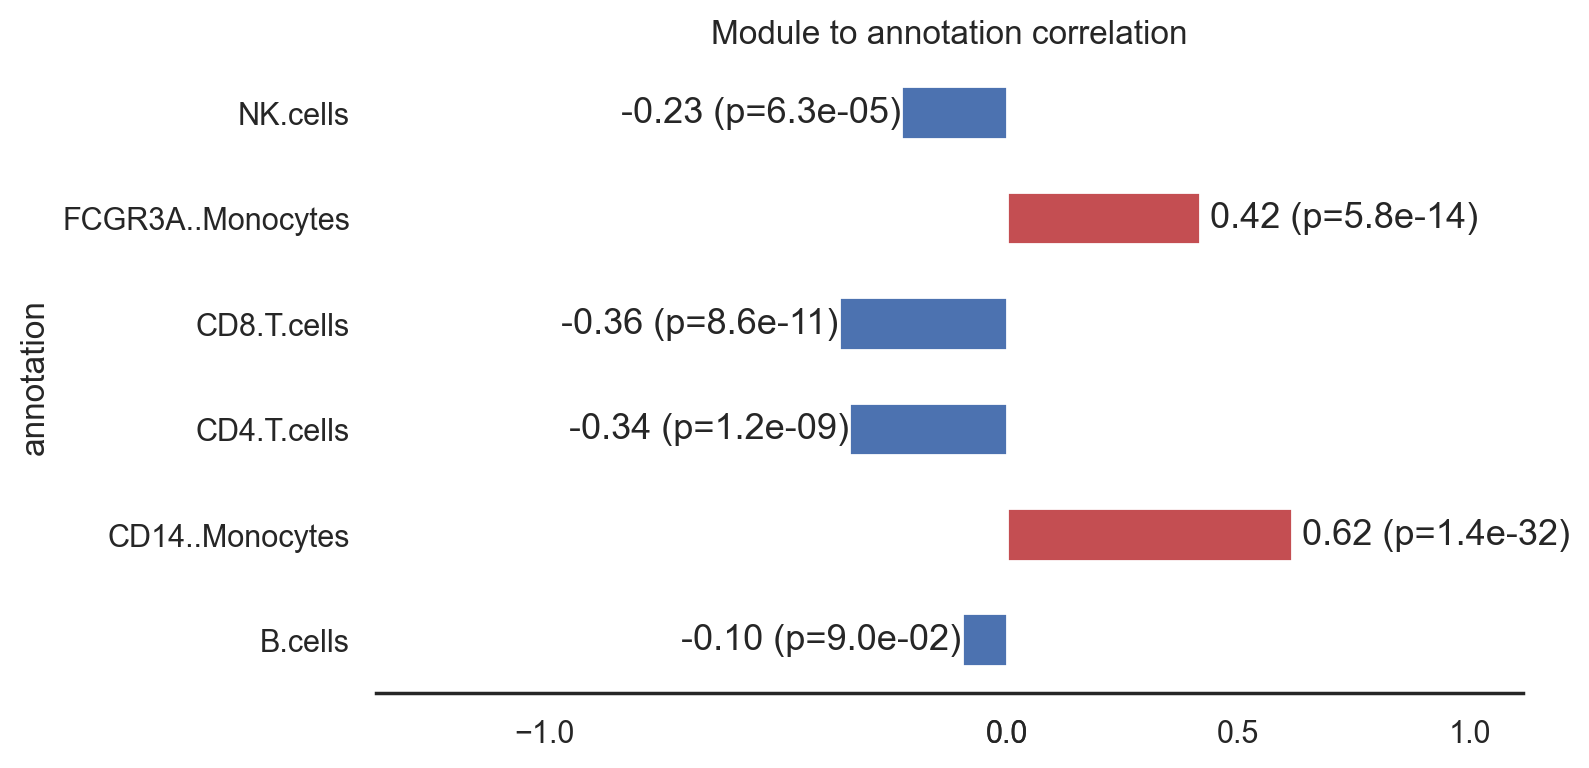

In [65]:
sn.co.module_to_annotation_cor(cor, module = M, figsize=(8,4))

Average module's gene expression in the different cell types

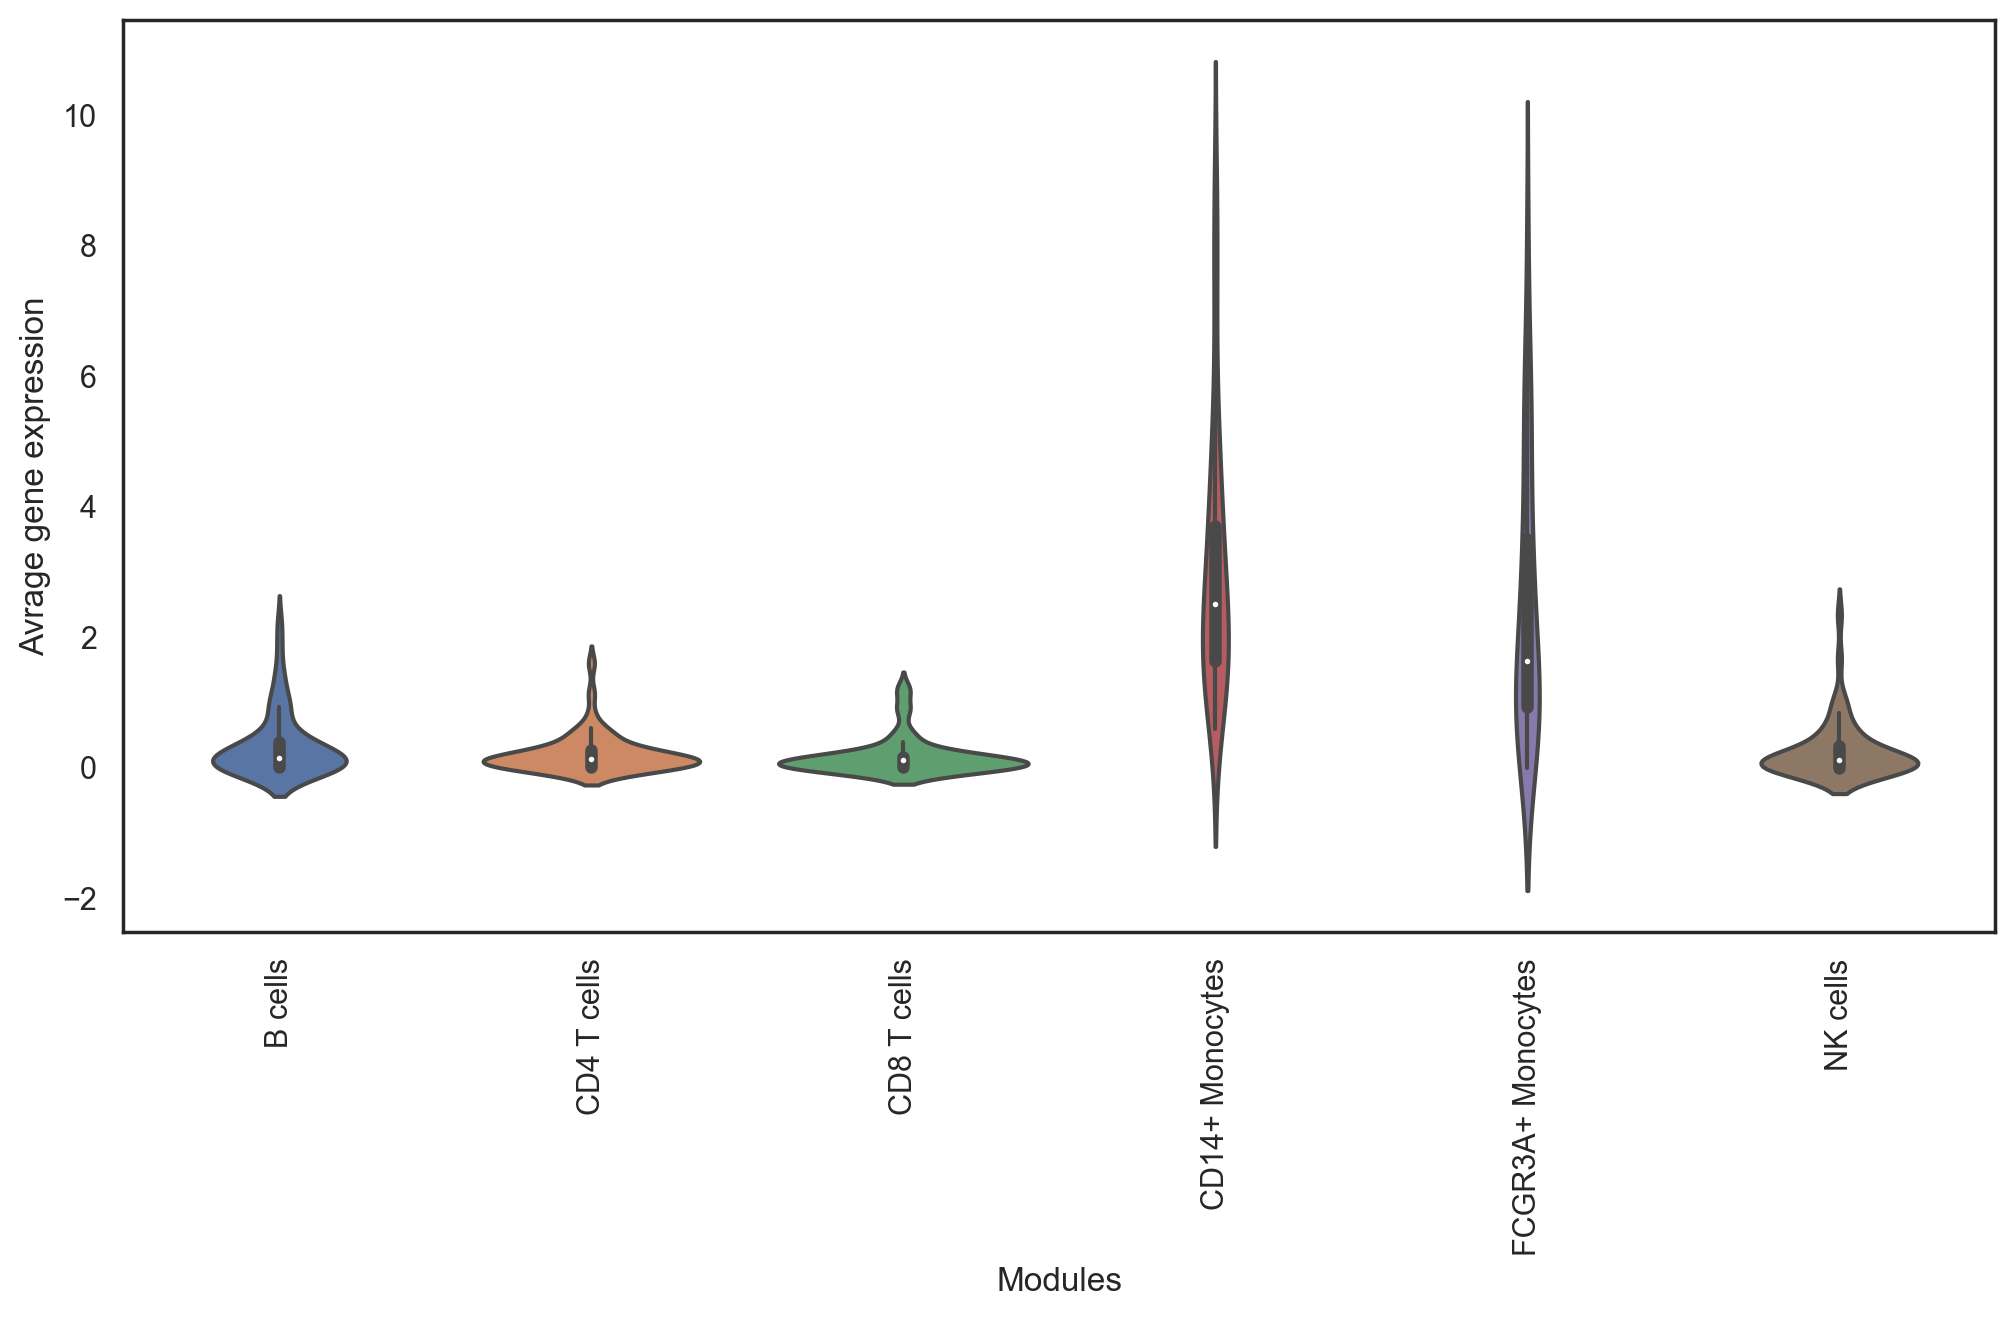

In [66]:
sn.co.Module_Genes_Avrage_Expr(module = M, adata = adata_r, figsize=(12,6))

Module membership (MM) (i.e., correlation of a gene to its module eigengene) across different cell types

Plotting Module Membership


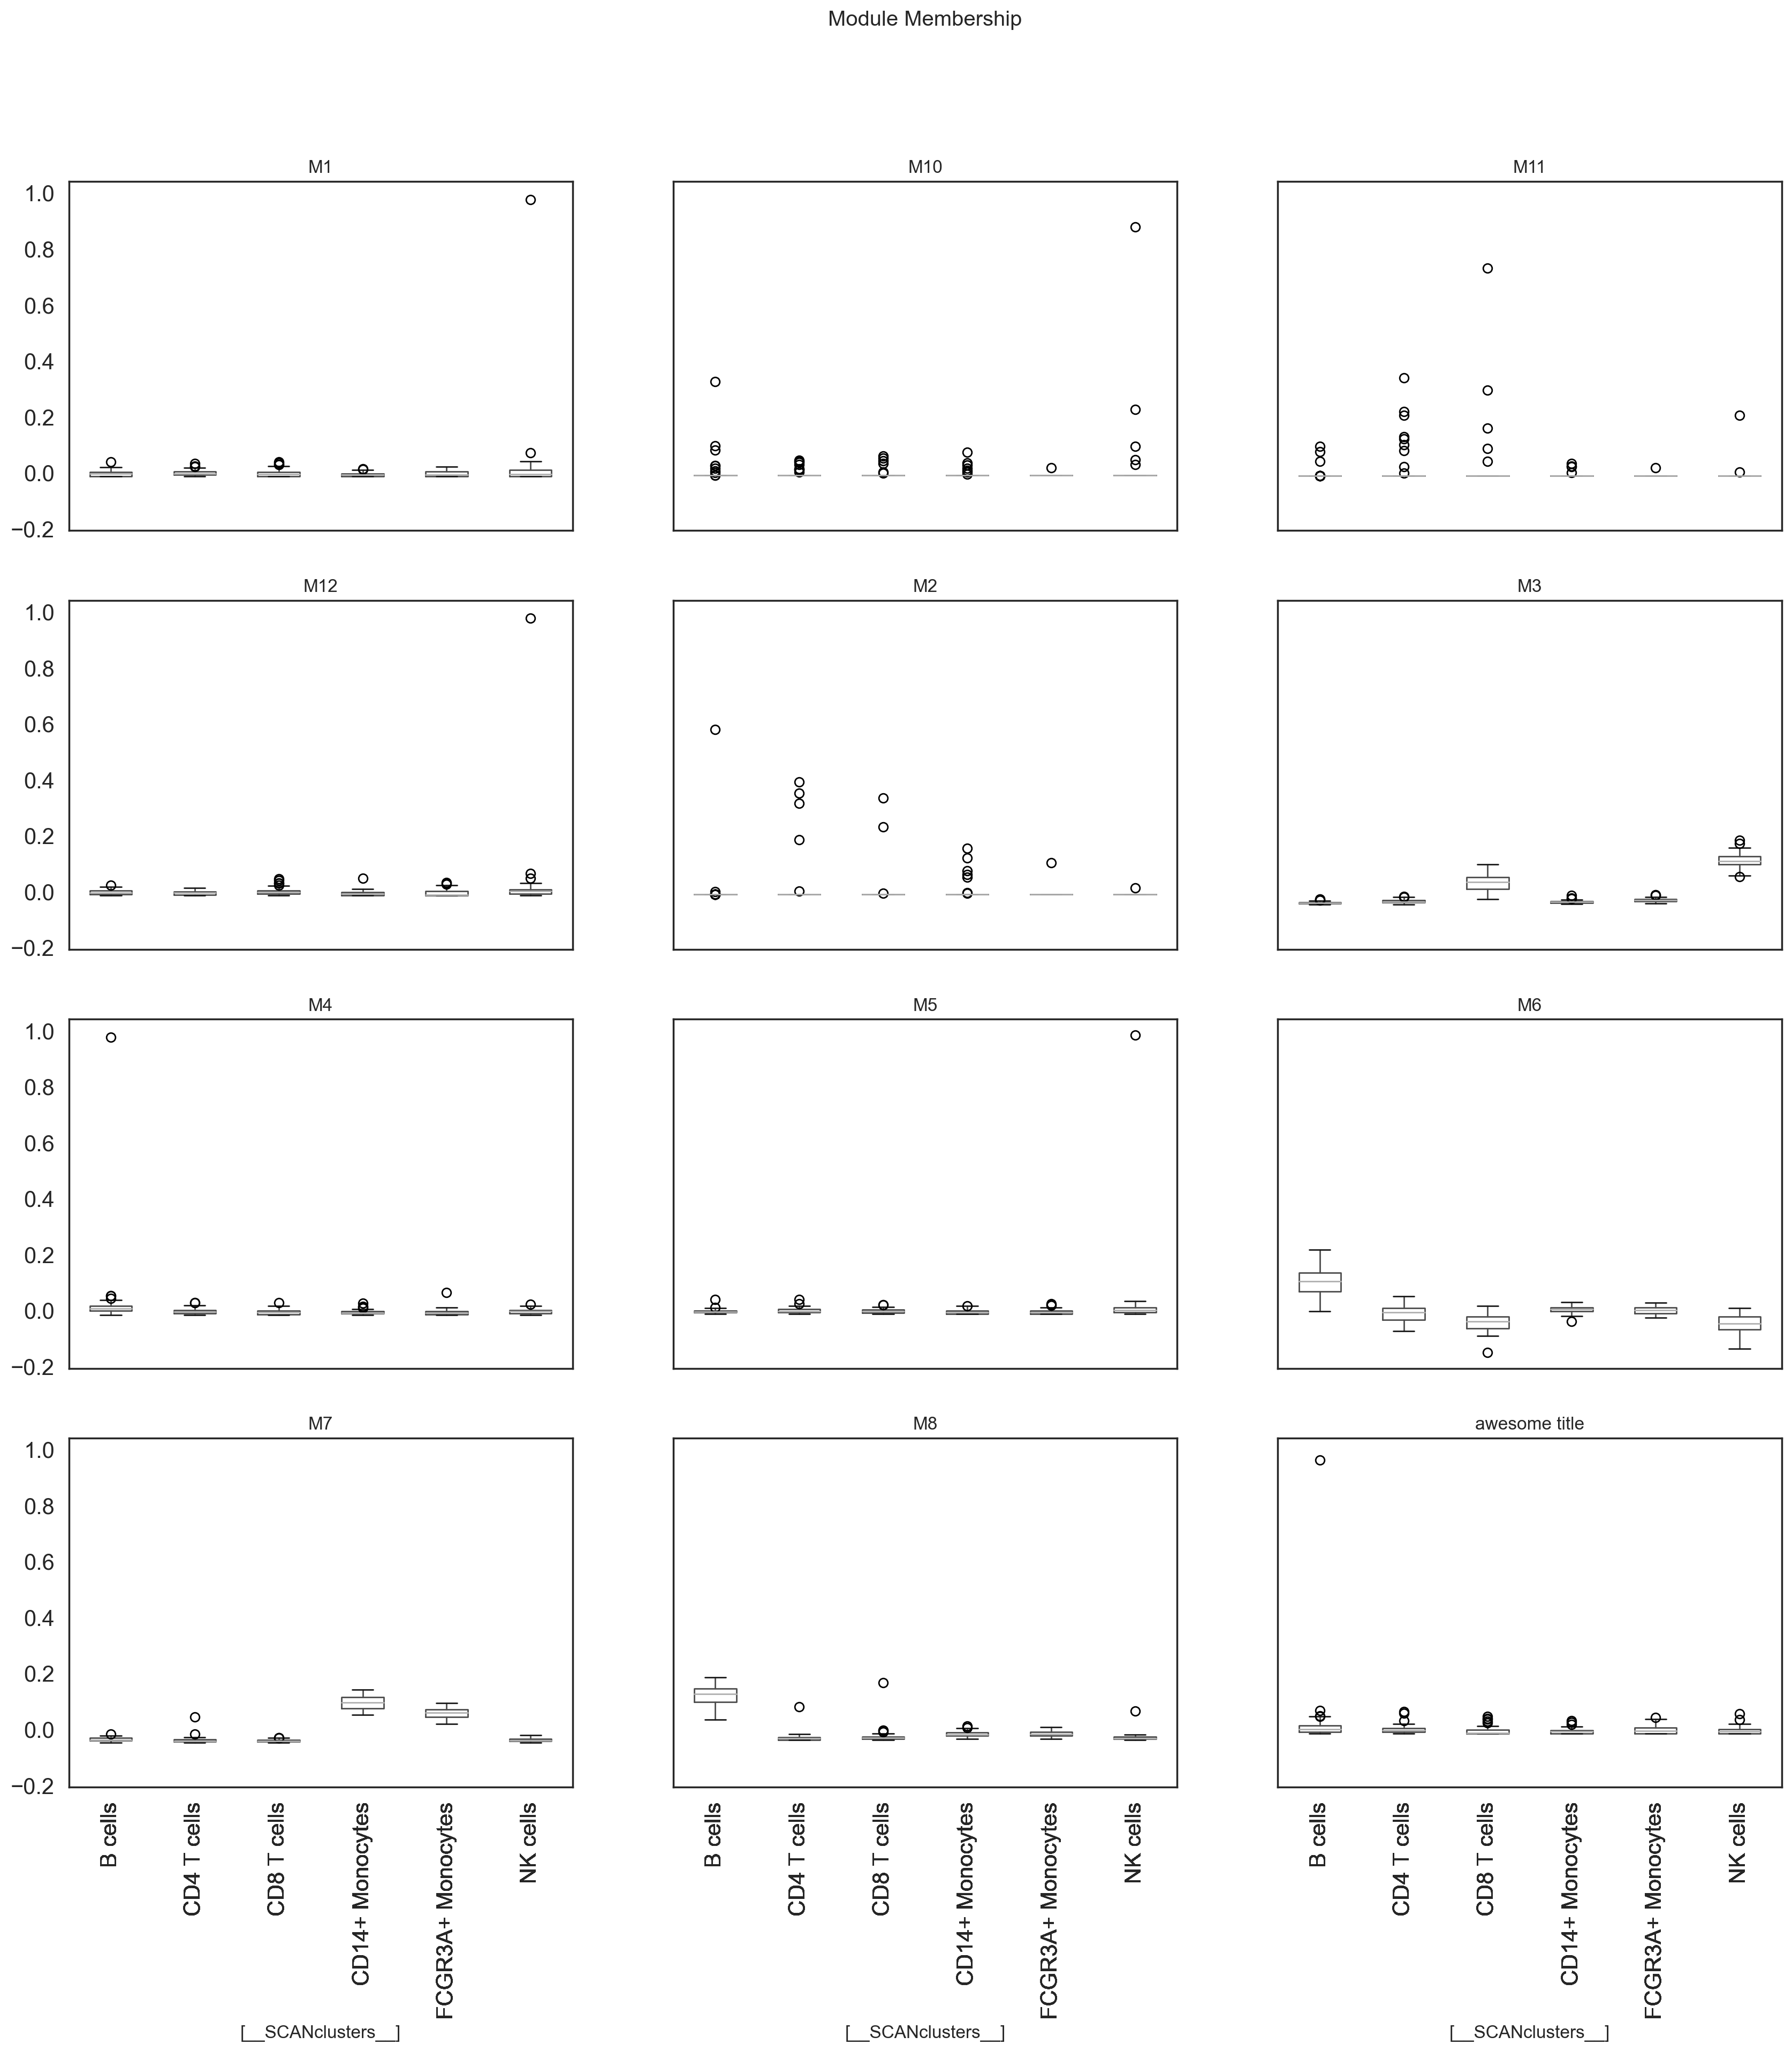

In [67]:
module_membership_df = sn.co.plot_module_membership(net, adata=adata_r, figsize=(20,20))

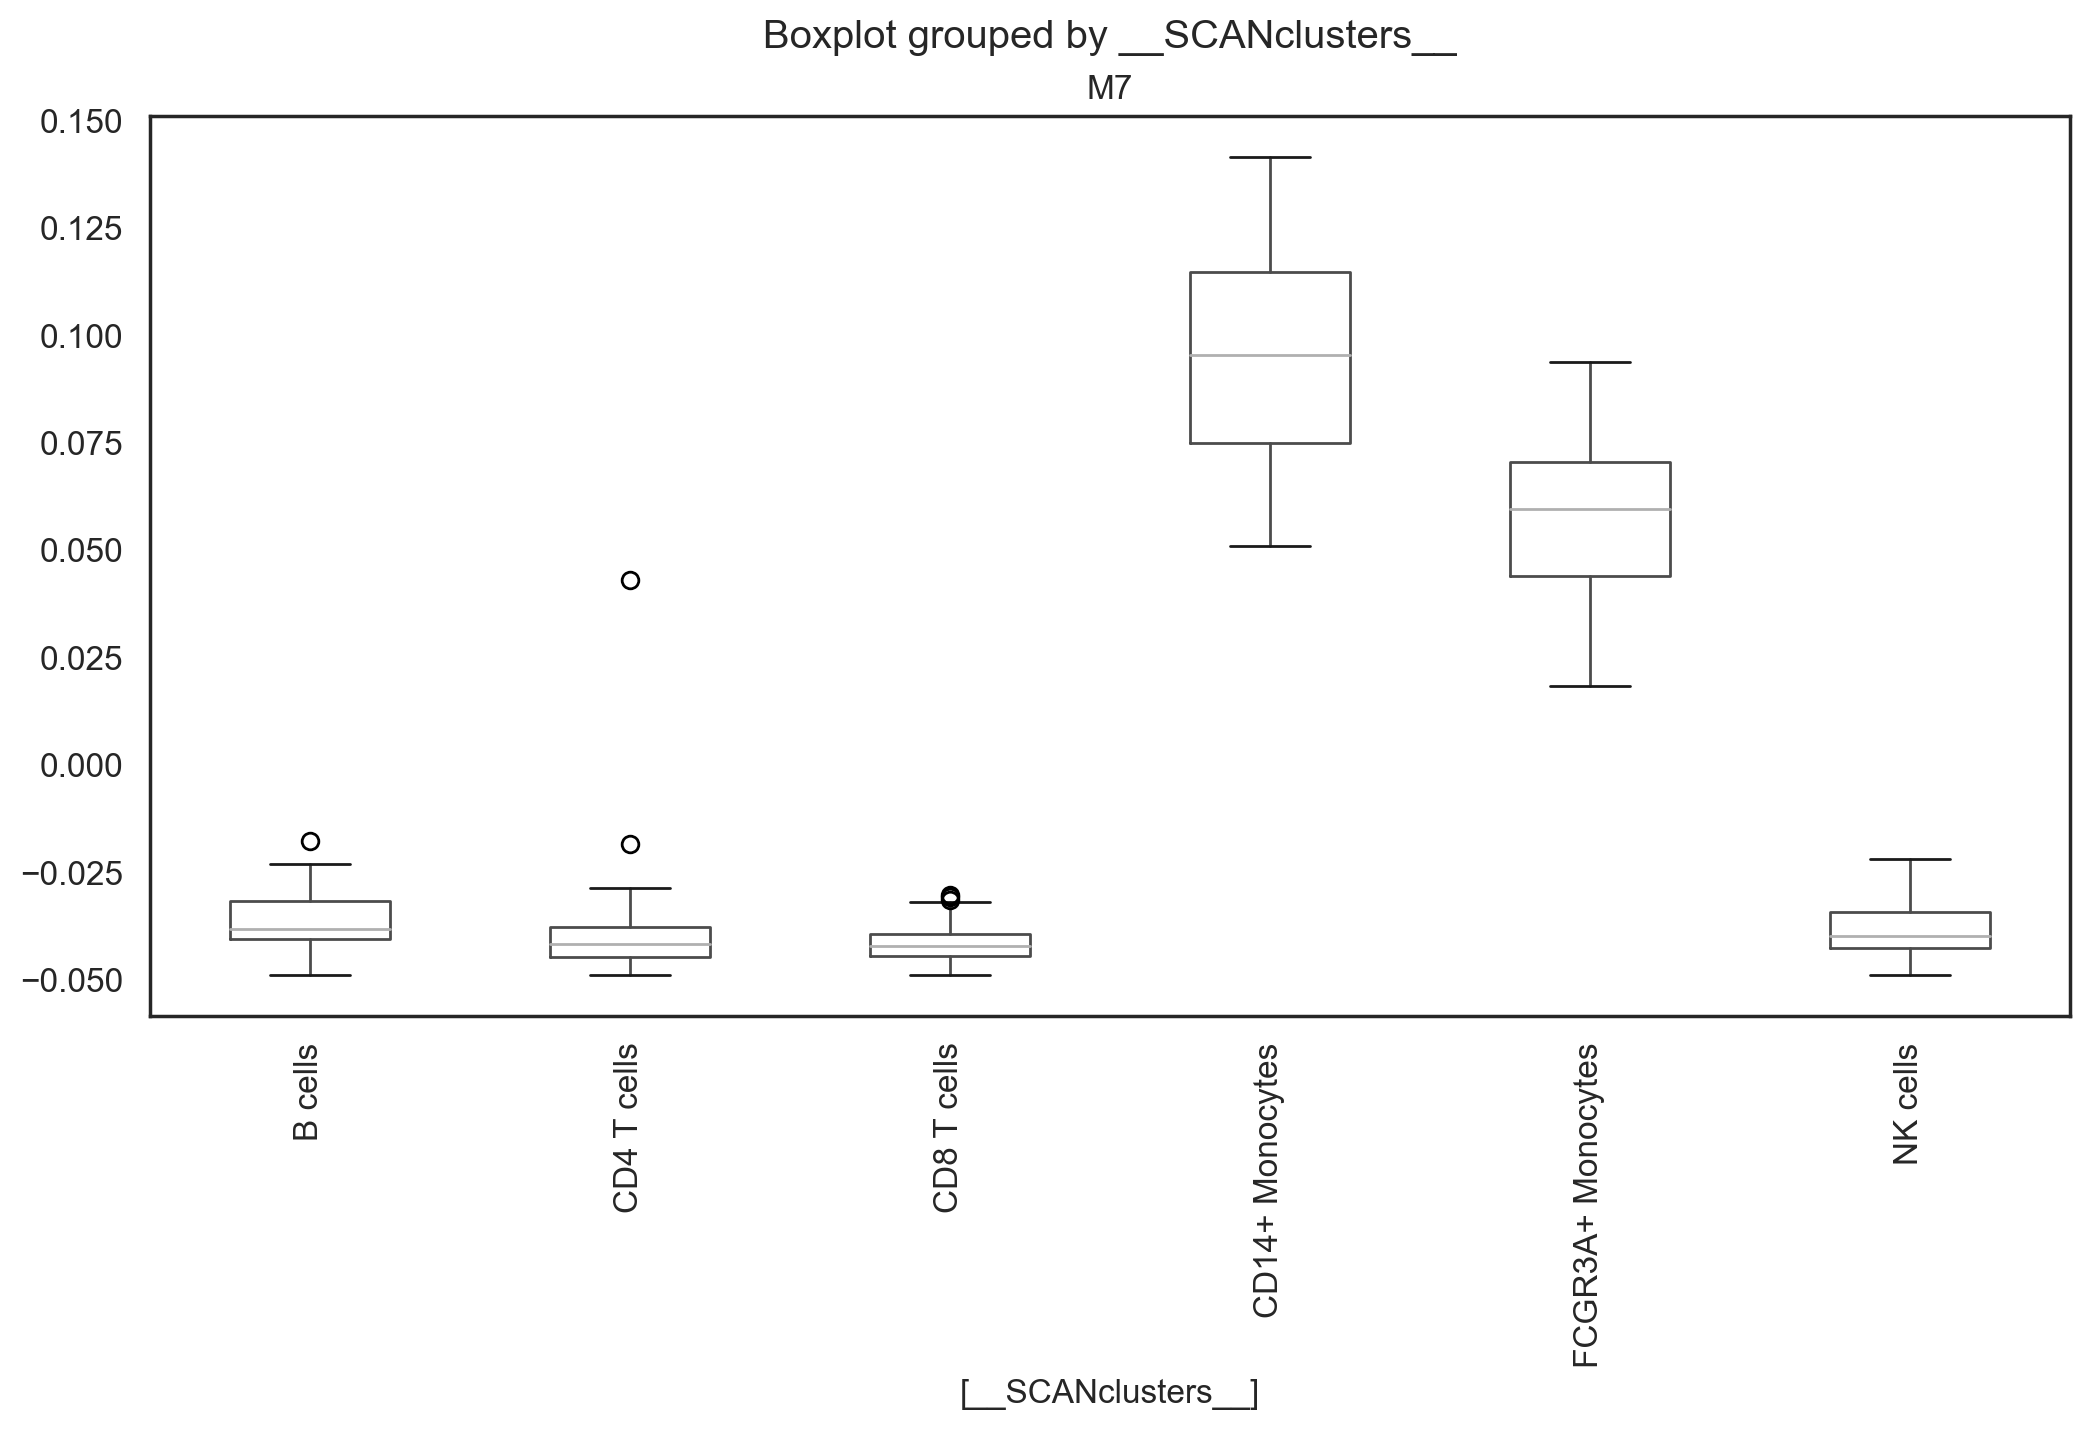

In [68]:
# Module membership of the selected module

sn.co.Module_Activity(module=M, plot_type="box", df = module_membership_df, figsize=(12,6))

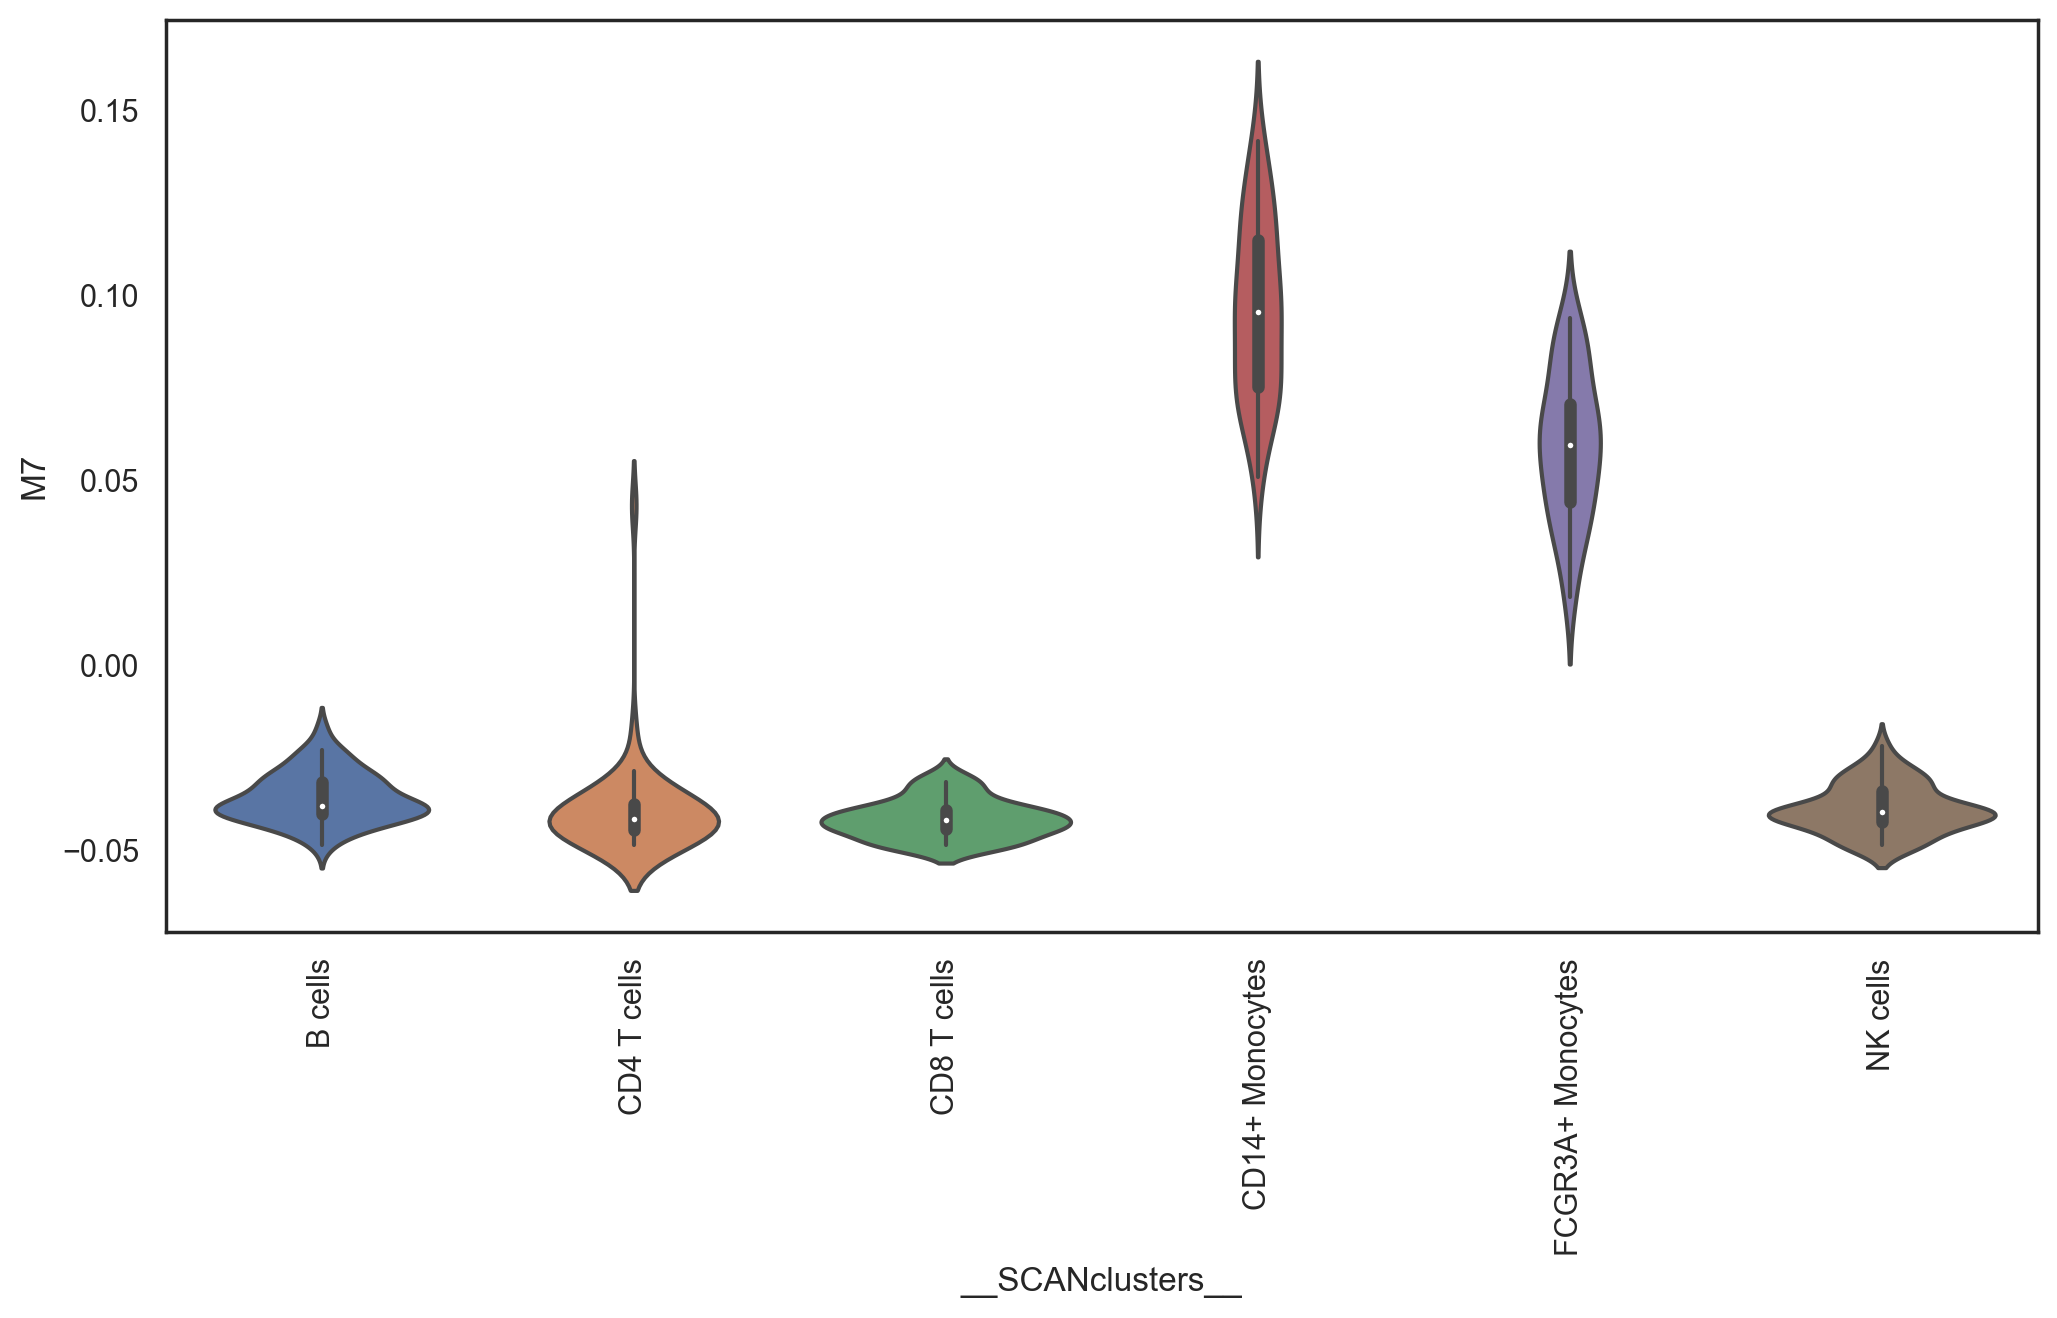

In [69]:
# Module membership of the selected module. violin plot.

sn.co.Module_Activity(module=M, plot_type="violin", df = module_membership_df, figsize=(12,6))

Subgraph extraction can be particularly useful to visualize specific modules, and it can be done with the function get_edge_list(). The function returns the subgraph as an edge list. in order to get the subgraph edges are removed based on minimum correlation (co_cutoff).

In [70]:
network_ = sn.co.module_to_network(net, module = M, co_cutoff=0.6)
print(network_.shape)
network_.head(5)

Your graph fits the scale-free topology. P-value:0.996468420969116
Using a correlation cut-off of 0.6 found 47 edges
There are 17 unique genes
(47, 4)


,Gene1,Gene2,Weight,Module
279,S100A9,S100A8,0.743428,M7
607,CSF3R,CD14,0.627432,M7
609,S100A9,CD14,0.659982,M7
611,S100A8,CD14,0.681525,M7
994,S100A9,FCN1,0.671737,M7


# Network visualization

As we now have an edge list for a module, let’s visualize it with the function plot_gcn().      
Hub genes and thier edges are given in red

In [71]:
sn.pl.plot_gcn(network_=network_,hub_genes_df=hub_genes_df, name="gcn_network", drug_interaction=False, smooth_edges=True)

Hub genes: ['CFD', 'CST3', 'S100A9', 'FCN1']


Here we enable the choice to also visualize the drugs targeting the genes within this module.     
The drugs have the green stars shape

Options for drug algorithms : "trustrank", "closeness", "degree" ....                             
The "drug target search" allows to select algorithms that will find genes related to the drugs.            
For more information about the algorithms, please refer to https://drugst.one/doc#implementation_algorithms.

In [72]:
sn.pl.plot_gcn(network_=network_,hub_genes_df=hub_genes_df, name="gcn+drugs", drug_interaction=True, algorithm="trustrank", smooth_edges=True)

Hub genes: ['CFD', 'CST3', 'S100A9', 'FCN1']


INFO:root:trustrank progress is at: 0.0%
INFO:root:trustrank progress is at: 0.0%
INFO:root:trustrank progress is at: 0.0%
INFO:root:trustrank progress is at: 0.0%
INFO:root:trustrank progress is at: 0.0%
INFO:root:trustrank is done.


[['Methyldopa', 'S100A9'], ['Methyldopa', 'S100A8'], ['Ruxolitinib', 'CSF3R'], ['Zinc chloride', 'S100A9'], ['Zinc chloride', 'S100A8'], ['Dasatinib', 'CSF3R'], ['Lovastatin', 'CD14'], ['Digoxin', 'CST3'], ['Pexidartinib', 'CSF3R'], ['Ribavirin', 'CST3'], ['Methotrexate', 'S100A8']]


# Gene regulatory network inference

In [73]:
# Load the modules Dataframe
import pandas as pd

modules_df = pd.read_csv("outs-scanet/genes_frequency_df.csv", index_col=0)
modules_df.head()

,Module_r,n_genes,genes,Modules
0,blue,30,"[""RP11-96K19.2"", ""AL590452.1"", ""RIT1"", ""BOLA3-...",M1
1,magenta,48,"[""CA6"", ""RP3-329E20.2"", ""PIFO"", ""AQP10"", ""SLC1...",M2
2,tan,59,"[""STMN1"", ""RHOC"", ""CD160"", ""SH2D2A"", ""FCRL6"", ...",M3
3,black,42,"[""HS2ST1"", ""LPGAT1"", ""EIF2AK3"", ""CD200"", ""U2SU...",M4
4,green,37,"[""MIB2"", ""DHRS3"", ""EVA1B"", ""CEPT1"", ""CHI3L2"", ...",M5


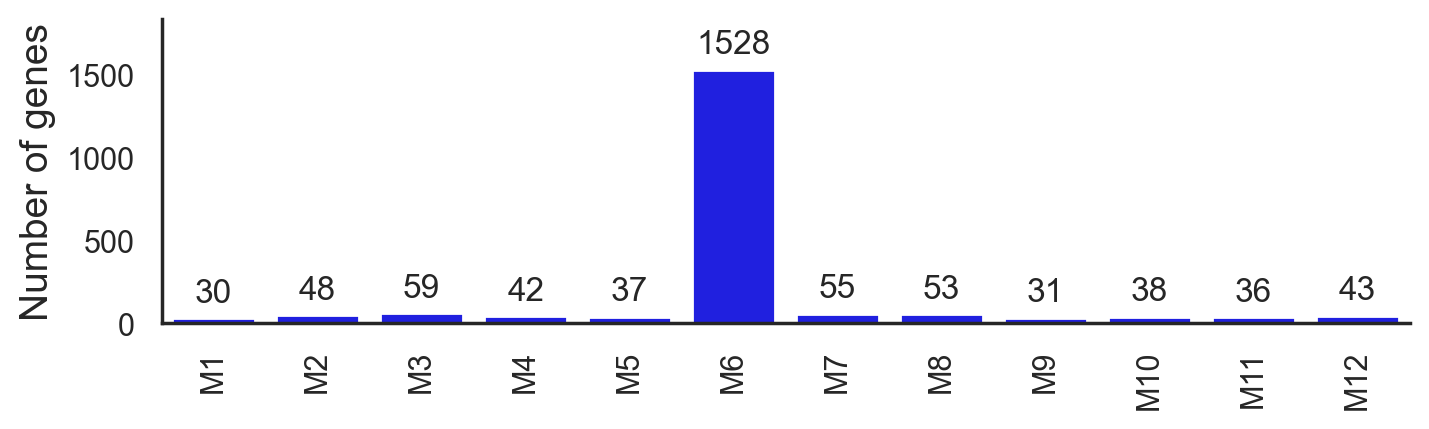

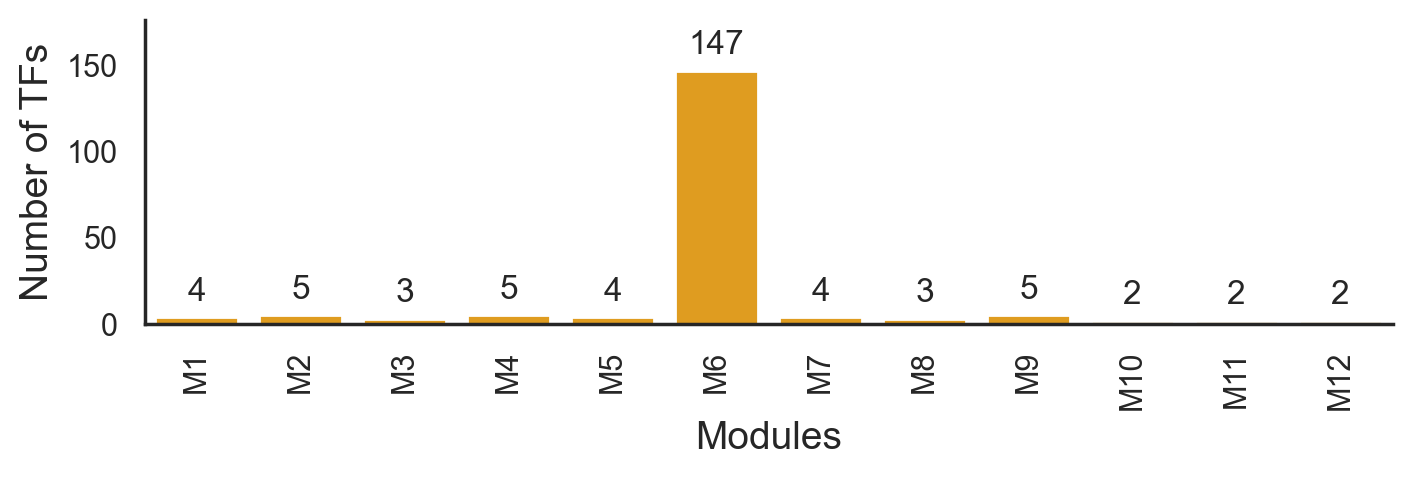

In [74]:
# Detect the modules genes that are also transcription factors
# A module with no transcription factors genes cannot be used in the GRN analysis!

specie_ = 'human'
sn.grn.regulators_count(modules_df = modules_df, specie = specie_, figsize=(8,2))

In [77]:
#The GRN analysis is done on the full data
# Get all processed data not the reduced one

adata_processed = sn.pp.read_h5ad("data/pbmc3k_raw_processed.h5ad", pr_process="skip")
adata_processed.obs.groupby([cell_annoatation]).size()

louvain
CD4 T cells          1110
CD14+ Monocytes       448
B cells               319
CD8 T cells           307
NK cells              151
FCGR3A+ Monocytes     124
Dendritic cells        18
Megakaryocytes          4
dtype: int64

In [78]:
# remove all cluster not analyzed !important!

for x in list(set(list(adata_processed.obs[cell_annoatation]))):
    if x not in list(set(list(adata_r.obs["__SCANclusters__"]))):
        adata_processed = adata_processed[adata_processed.obs[cell_annoatation] != x]
adata_processed.obs.groupby([cell_annoatation]).size()

louvain
CD4 T cells          1110
CD14+ Monocytes       448
B cells               319
CD8 T cells           307
NK cells              151
FCGR3A+ Monocytes     124
dtype: int64

GRN analysis parameters       
anno_name: cell type or any cell annotation indicating in which cell group where the GRN will be inferences.     
groupby_: The key of the observation in the anndata.obs corresponding to the cell clustering to be used.      
Mod_: GCN module to be mapped to GRN 

subsampling:
The data we are handling is often noisy and sparse despite the preprocessing and filtering. Furthermore, the single-cell data capture a temporal snapshot, where cells are in different states and phases, which leads to cell-to-cell heterogeneity and an abundance of intermediate states. In other words, the gene expression profiles vary even within the same cell type, which is a major obstacle in understanding the underlying regulatory dynamics within the data. To overcome this, we reasoned that randomly subsampling cells and learning multiple scGRN and combining them into one large scGRN will permit us to eliminate the signals sourced from noise and outlier cells. Through the examination of multiple scGRN, we can distinguish the conserved signals across the sample and the ones from noise. subsampling is an important step to eliminate the noise and therefore accurate scGRN construction, which is crucial for the further steps. 

This done using:                   
n_iteration: Number of time to compute scGRN                 
subsampling_pct: Percentage of cells to include in every random sub-sample

A scGRN is computed for each sub-sample resulted from the subsampling step. Next, the sub-sample-based scGRNs are combined into one accurate scGRN.  The alignment procedure associates an occurrence rate for every edge, which measures the frequency with which the edge occurs across all scGRNs. Considering that we are interested in capturing the biological insights that are homogeneous within each sample, edges with low occurrence rates mostly emerge from outlier or Inferior sets of cells, and those are to be filtered out. The remaining edges compose the final sample-based scGRN.

one can set an occurrence threshold based on this rate to filter the low confidence edges. We recommend 80%.

In [79]:
print(anno_name_)

['CD14..Monocytes']


In [80]:
# GRN analysis parameters

anno_name = "CD14+ Monocytes"
groupby_ = cell_annoatation
Mod_ = M
num_workers = 60
n_iteration = 10

Get the ranking databases                      
See for more details : https://pyscenic.readthedocs.io/en/latest/tutorial.html

In [82]:
sn.download_db()

Do you want to install datasets for (human/mouse/both)?
human
Human dataset is already downloaded!


In [83]:
# GRN inference

grn_df = sn.grn.grn_inference(adata_processed=adata_processed,modules_df=modules_df, module=Mod_, groupby_=groupby_, anno_name=anno_name, specie=specie_, subsampling_pct=80, n_iteration=n_iteration, num_workers=num_workers)

This Module has 55 genes.
4 Genes in this modules are regulatores (TFs).
TFs are: ['KLF4', 'HHEX', 'SPI1', 'POU2F2']
The anndata size after gene filtring (2459, 55) ...
Using anootation : CD14+ Monocytes found 448 cells.
runing : 10 iteration ...
/tmp/tmpxpr8gzpc/ngbsxglofb_adata.loom
Subsampling using 80% ...
Using 358 cells after sub-sampling ...
/tmp/tmpxpr8gzpc/hbudyamdxp_adata.loom
Subsampling using 80% ...
Using 358 cells after sub-sampling ...
/tmp/tmpxpr8gzpc/nvtxntfiaf_adata.loom
Subsampling using 80% ...
Using 358 cells after sub-sampling ...
/tmp/tmpxpr8gzpc/rlaxijmovw_adata.loom
Subsampling using 80% ...
Using 358 cells after sub-sampling ...
/tmp/tmpxpr8gzpc/mhcjlelqas_adata.loom
Subsampling using 80% ...
Using 358 cells after sub-sampling ...
/tmp/tmpxpr8gzpc/ircstucgma_adata.loom
Subsampling using 80% ...
Using 358 cells after sub-sampling ...
/tmp/tmpxpr8gzpc/ycqyazubul_adata.loom
Subsampling using 80% ...
Using 358 cells after sub-sampling ...
/tmp/tmpxpr8gzpc/gpxdxjqm

 18%|███████▋                                  | 10/55 [00:00<00:00, 89.90it/s]

Loaded expression matrix of 358 cells and 55 genes in 0.007675886154174805 seconds...
Loaded 4 TFs...
starting grnboost2 using 60 processes...
Done in 0.7977797985076904 seconds.
Done in 0.8201823234558105 seconds.
Done in 0.896752119064331 seconds.
Done in 0.8171532154083252 seconds.


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 466.88it/s]


Done in 0.7759714126586914 seconds.


  0%|                                                   | 0/55 [00:00<?, ?it/s]

Ranking dbsRanking dbs
['/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-500bp-upstream-10species-v2.mc9nr.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-500bp-upstream-7species-v2.mc9nr.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-10kb-10species-v2.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-10kb-7species-v2.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-5kb-7species-v2.genes_vs_motifs.rankings.feather']

This the command
['pysc

100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 458.30it/s]



This the command
['pyscenic', 'ctx', '/tmp/tmp22mfhpny/grn.csv', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-500bp-upstream-10species-v2.mc9nr.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-500bp-upstream-7species-v2.mc9nr.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-10kb-10species-v2.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-10kb-7species-v2.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-5kb-7species-v2.genes_vs_motifs.r

100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 552.30it/s]


Ranking dbs
['/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-500bp-upstream-10species-v2.mc9nr.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-500bp-upstream-7species-v2.mc9nr.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-10kb-10species-v2.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-10kb-7species-v2.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-5kb-7species-v2.genes_vs_motifs.rankings.feather']
This the command
['pyscenic', 'ctx'

['pyscenic', 'ctx', '/tmp/tmpj627b_3w/grn.csv', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-500bp-upstream-10species-v2.mc9nr.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-500bp-upstream-7species-v2.mc9nr.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-10kb-10species-v2.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-10kb-7species-v2.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather', '/home/baz8031/miniconda3/envs/scan/lib/python3.9/site-packages/scanet/databases/human/hg19-tss-centered-5kb-7species-v2.genes_vs_motifs.rankings.feather', 


2022-10-10 11:03:44,594 - pyscenic.cli.pyscenic - INFO - Creating modules.

2022-10-10 11:03:44,599 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-10-10 11:03:44,606 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-10-10 11:03:44,607 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2022-10-10 11:03:44,613 - pyscenic.utils - INFO - Creating modules.

2022-10-10 11:03:44,644 - pyscenic.cli.pyscenic - I


2022-10-10 11:03:45,474 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-10-10 11:03:45,475 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2022-10-10 11:03:45,481 - pyscenic.utils - INFO - Creating modules.

2022-10-10 11:03:45,494 - pyscenic.cli.pyscenic - INFO - Loading databases.

2022-10-10 11:03:45,569 - pyscenic.cli.pyscenic - INFO - Loading databases.

2022-10-10 11:03:45,573 - pyscenic.cli.pyscenic - INFO - C

[########################################] | 100% Completed | 117.20 s
[                                        ] | 0% Completed | 117.64 s


2022-10-10 11:05:44,822 - pyscenic.cli.pyscenic - INFO - Writing results to file.


[                                        ] | 0% Completed | 118.43 sCreate regulons from a dataframe of enriched features.
Additional columns saved: []
found 28 edges
[########################################] | 100% Completed | 132.46 s
[                                        ] | 0% Completed | 132.41 s


2022-10-10 11:05:59,674 - pyscenic.cli.pyscenic - INFO - Writing results to file.


[                                        ] | 0% Completed | 133.06 sCreate regulons from a dataframe of enriched features.
Additional columns saved: []
[                                        ] | 0% Completed | 133.32 sfound 32 edges
[########################################] | 100% Completed | 134.55 s
[########################################] | 100% Completed | 134.67 s
[                                        ] | 0% Completed | 134.71 s


2022-10-10 11:06:01,855 - pyscenic.cli.pyscenic - INFO - Writing results to file.


[                                        ] | 0% Completed | 135.43 sCreate regulons from a dataframe of enriched features.
Additional columns saved: []
found 30 edges
[                                        ] | 0% Completed | 135.92 s


2022-10-10 11:06:03,176 - pyscenic.cli.pyscenic - INFO - Writing results to file.


[                                        ] | 0% Completed | 136.57 sCreate regulons from a dataframe of enriched features.
Additional columns saved: []
found 34 edges
[########################################] | 100% Completed | 149.06 s
[                                        ] | 0% Completed | 150.00 s


2022-10-10 11:06:17,118 - pyscenic.cli.pyscenic - INFO - Writing results to file.


[                                        ] | 0% Completed | 150.50 sCreate regulons from a dataframe of enriched features.
Additional columns saved: []
found 43 edges
[########################################] | 100% Completed | 152.71 s
[                                        ] | 0% Completed | 154.15 s


2022-10-10 11:06:21,452 - pyscenic.cli.pyscenic - INFO - Writing results to file.


[                                        ] | 0% Completed | 155.40 sCreate regulons from a dataframe of enriched features.
Additional columns saved: []
found 31 edges
[########################################] | 100% Completed | 185.43 s
[                                        ] | 0% Completed | 186.01 s


2022-10-10 11:06:53,185 - pyscenic.cli.pyscenic - INFO - Writing results to file.


[                                        ] | 0% Completed | 186.71 sCreate regulons from a dataframe of enriched features.
Additional columns saved: []
found 35 edges
[########################################] | 100% Completed | 215.42 s
[                                        ] | 0% Completed | 215.57 s


2022-10-10 11:07:22,859 - pyscenic.cli.pyscenic - INFO - Writing results to file.


[                                        ] | 0% Completed | 216.07 sCreate regulons from a dataframe of enriched features.
Additional columns saved: []
[                                        ] | 0% Completed | 216.42 sfound 40 edges
[########################################] | 100% Completed | 236.26 s
[                                        ] | 0% Completed | 236.92 s


2022-10-10 11:07:44,146 - pyscenic.cli.pyscenic - INFO - Writing results to file.


[                                        ] | 0% Completed | 237.22 sCreate regulons from a dataframe of enriched features.
Additional columns saved: []
[                                        ] | 0% Completed | 237.52 sfound 43 edges
[########################################] | 100% Completed | 246.74 s



2022-10-10 11:07:54,735 - pyscenic.cli.pyscenic - INFO - Writing results to file.


Create regulons from a dataframe of enriched features.
Additional columns saved: []
found 53 edges
Analysis done ...


In run 0: 43 edges where found.
In run 1: 28 edges where found.
In run 2: 31 edges where found.
In run 3: 34 edges where found.
In run 4: 30 edges where found.
In run 5: 53 edges where found.
In run 6: 35 edges where found.
In run 7: 40 edges where found.
In run 8: 43 edges where found.
In run 9: 32 edges where found.


In [84]:
# GRN
#one can set an occurrence threshold based on this rate to filter the low confidence edges. 
#We recommend 80%.

print(grn_df.shape)
grn_df = grn_df.sort_values(by=['occurrence(pct)'], ascending=False)
grn_df.head(6)
# Save for later use
# grn_df.to_csv('outs/grn_df.csv')

(74, 3)


,TF,TG,occurrence(pct)
38,SPI1,ALDH2,100.0
67,SPI1,PLBD1,100.0
45,SPI1,CPVL,100.0
69,SPI1,SPI1,100.0
43,SPI1,CFD,100.0
70,SPI1,TMEM176B,100.0


# Network visualization

GRN visualization     
The TF (orange triangles) and their target genes
one can visualize the whole network or just select regulon(s) (a TF and its target genes) of interest in case of huge networks using [regulon] parameter.

In [85]:
sn.pl.plot_grn(df=grn_df, occurrence_pct=80, name="GRN_net", regulon="all", layout="None")


 Out of 74 edges, 23 edges satisfying occurrence threshold 80% where kept 

['SPI1']
(23, 3)
None


Here we enable the choice to also visualize the drugs targeting the genes within this module.     
The drugs have the green stars shape

In [86]:
sn.pl.plot_grn(df=grn_df, occurrence_pct=80, regulon="all", layout="None", drug_interaction="direct")


 Out of 74 edges, 23 edges satisfying occurrence threshold 80% where kept 

['SPI1']
(23, 3)
None


INFO:root:degree progress is at: 0.0%
INFO:root:degree progress is at: 0.0%
INFO:root:degree progress is at: 0.0%
INFO:root:degree progress is at: 0.0%
INFO:root:degree progress is at: 0.0%
INFO:root:degree is done.
